<a href="https://colab.research.google.com/github/oamerl/machine-learning-projects/blob/main/Deep-Learning/airbnb-price-category-prediction/airbnb_price_category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Needed Questions


Introduction

* Multi-objective/Multi-task learning is a paradigm in which we predict multiple outputs instead of just one. We used it in this assignment by predicting the "Price" and "Type" of the apartment.
* Multi-modality learning is another learning paradigm in which we use different modalities (different data types) such as images, text, sound, videos ..etc and fuse these modalities to predict the needed label. In the assignment we used multi-modality by using both the apartment "images" and their text "summary" to predict our target label.
* In this project we used multi-task mult-modality in which we used both images and text to predict both "Price" and "Type".


## **2- Data Downloading 📥**

Since the data is large ~ 0.6 GB we will get it directly from Kaggle to avoid re-uploading it to colab several times when faced by runtime issues.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle # making new directory
! cp kaggle.json ~/.kaggle/ # copying kaggle json file to the created directory
! chmod 600 ~/.kaggle/kaggle.json # changing the permissions
! kaggle competitions download -c copy-of-cisc-873-dm-w23-a4 # downloading the competition data

100% 603M/604M [00:32<00:00, 21.1MB/s]
100% 604M/604M [00:32<00:00, 19.3MB/s]


In [ ]:
! mkdir assign4_data # making new directory on colab session to unzip the dataset in it
! unzip -q copy-of-cisc-873-dm-w23-a4.zip -d assign4_data # unzipping the downloaded data

## **3- Data Import and Exploration 💡**

Importing Needed Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import pickle

Importing the Data

In [ ]:
train_df = pd.read_csv("/content/assign4_data/a4/train_xy.csv")
test_df = pd.read_csv("/content/assign4_data/a4/test_x.csv")

# /content/assign4_data/a4/img_test/
# /content/assign4_data/a4/img_train/

Exploring the Data

In [ ]:
# checking the training dataframe contents
train_df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


In [ ]:
# checking the testing dataframe contents
test_df

,id,summary,image
0,0,Charming warm house is ready to host you here ...,img_test/0.jpg
1,1,"La chambre est spacieuse et lumineuse, dans un...",img_test/1.jpg
2,2,Grande chambre confortable située au sous-sol ...,img_test/2.jpg
3,3,"Près d’un Métro, ligne orange. 10 minutes à pi...",img_test/3.jpg
4,4,Very bright appartment and very cosy. 2 separa...,img_test/4.jpg
...,...,...,...
7355,7626,"Large, fully-furnished flat with brick walls a...",img_test/7627.jpg
7356,7627,Logement situé dans le haut d’un duplex. Vivez...,img_test/7628.jpg
7357,7628,"My place is close to parks, . My place is good...",img_test/7629.jpg
7358,7629,"*** For security reasons, I will prioritize gu...",img_test/7630.jpg


In [ ]:
# checking datatypes and if there are any null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7627 entries, 0 to 7626
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  7326 non-null   object
 1   image    7627 non-null   object
 2   type     7627 non-null   object
 3   price    7627 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.5+ KB


Nulls Count per column

We notice that there are missing values in the "summary" column. we will drop these N/A at the preprocessing section

In [ ]:
nulls = train_df.isnull().sum().sort_values(ascending=False) # nulls per column
nulls[nulls>0] # filtering on columns(features) having missing values

summary    301
dtype: int64

Duplicate rows checking

In [ ]:
# lets drop any duplicate rows (if any)
print(train_df.duplicated().sum(), "duplicate entries are found")
#train_df.drop_duplicates(inplace=True)

0 duplicate entries are found


In [ ]:
# checking the values count of the target label (price)
print(train_df['price'].value_counts())

0    4737
1    2403
2     487
Name: price, dtype: int64


In [ ]:
# checking the values count of the target label (type)
print(train_df['type'].value_counts())

Apartment                 5765
Condominium                691
House                      406
Loft                       324
Townhouse                  167
Serviced apartment          77
Bed and breakfast           38
Guest suite                 32
Hostel                      26
Bungalow                    25
Guesthouse                  14
Cottage                     12
Aparthotel                  12
Boutique hotel              10
Other                        8
Villa                        7
Tiny house                   3
Boat                         2
Cabin                        2
Camper/RV                    2
Casa particular (Cuba)       1
Hotel                        1
Earth house                  1
Castle                       1
Name: type, dtype: int64


In [ ]:
# get the total number of unique outputs (later used for softmax layer number of o/p neurons)
len_aprt_type = len(train_df.type.unique())
len_price_categ = len(train_df.price.unique())

print(f"we have {len_aprt_type} unique apartment types")
print(f"we have {len_price_categ} unique price categories")

we have 24 unique apartment types
we have 3 unique price categories


## **4- Data Preprocessing 🧼**

### General Preprocessing

Missing Values Removal

In [ ]:
# Dropping missing values from "summary"
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7326 entries, 0 to 7626
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  7326 non-null   object
 1   image    7326 non-null   object
 2   type     7326 non-null   object
 3   price    7326 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 286.2+ KB


Target Labels Preprocessing

In [ ]:
# labels encoding
train_df['type'] = train_df.type.astype('category').cat.codes

In [ ]:
# checking if the encoding is done
train_df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,1,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,1,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,1,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,1,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,1,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,1,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,1,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,1,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,1,0


Getting the target labels to be passed later for the model

In [ ]:
# get apartmnent type
y_train_type = train_df.type

# get price category
y_train_price = train_df.price

### Image Data Preprocessing

We will first check a sample image and print its characteristics

image dimensions: (480, 1010, 3)
range: [0.0000, 255.0000]
data type: uint8


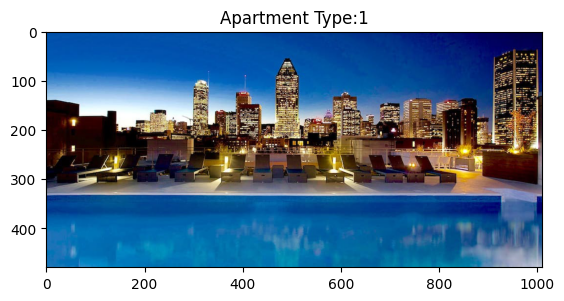

In [ ]:
import matplotlib.pyplot as plt
images_folder = "/content/assign4_data/a4/" # path of images folder on colab session
image_index = 1 # index of the image to be plotted
sample_image_path = images_folder + train_df.image[image_index] # /content/assign4_data/a4/img_train/image_index.jpg

sample_image = plt.imread(sample_image_path) # reading the specified image
fig = plt.figure()
plt.imshow(sample_image)
plt.title(f"Apartment Type:{train_df.type[image_index]}")

# checking the printed image characteristics
print("image dimensions:", sample_image.shape)
mn = np.min(sample_image) # minimum pixel value
mx = np.max(sample_image) # maximum pixel value
print("range: [%.4f, %.4f]" % (mn, mx))
print("data type:", sample_image.dtype)

Then here we are checking the output of the transformation that will be applied on all images to see its effect first on the sample image before proceeding in applying on the images

image dimensions: (128, 128, 2)
range: [0.0000, 255.0000]
data type: uint8


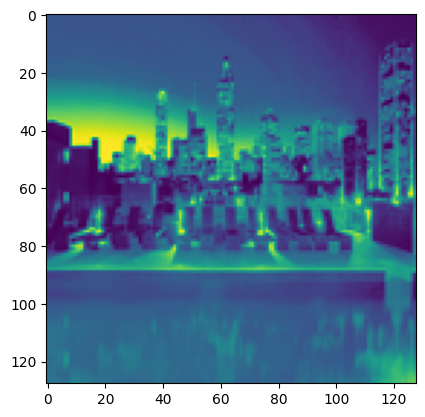

In [ ]:
sample_image_edited = np.array(Image.open(sample_image_path).convert('LA').resize((128,128))) # we resize image and convert it to 'LA' which is a 2 channel image representation
plt.imshow(np.array(sample_image_edited[:, :, 0])) # take first channel after converting, if you didn't index it, it will raise an error

# checking the printed image characteristics
print("image dimensions:", sample_image_edited.shape)
mn = np.min(sample_image_edited) # minimum pixel value
mx = np.max(sample_image_edited) # maximum pixel value
print("range: [%.4f, %.4f]" % (mn, mx))
print("data type:", sample_image_edited.dtype)

Now we will apply the transformation on all images by creating a function that will be given the image path and it will return the converted image. If image file cannot be read an equivalent image of all black will be returned instead.

In [ ]:
# preprocess image data

def load_image(file):
    try:
        image = Image.open(file).convert('LA').resize((128, 128)) # .convert('LA') LA is 8-bit pixels, grayscale with alpha (2 channel image)
        arr = np.array(image)

    except:
        arr = np.zeros((128, 128, 2)) # if image reading failed for any reasoon

    return arr

In [ ]:
# loading images:
x_train_image_paths = [images_folder + train_image_subpath for train_image_subpath in tqdm(train_df.image)] # list comprehension of training images paths
x_train_image = np.array([load_image(image_path) for image_path in tqdm(x_train_image_paths)]) # list comprehension and converting it to numpy array containing training images

x_test_image_paths = [images_folder + test_image_subpath for test_image_subpath in tqdm(test_df.image)] # list comprehension of testing images paths
x_test_image = np.array([load_image(image_path) for image_path in tqdm(x_test_image_paths)]) # list comprehension and converting it to numpy array containing testing images

  0%|          | 0/7326 [00:00<?, ?it/s]

  0%|          | 0/7326 [00:00<?, ?it/s]

  0%|          | 0/7360 [00:00<?, ?it/s]

  0%|          | 0/7360 [00:00<?, ?it/s]

train image dimensions (7326, 128, 128, 2)


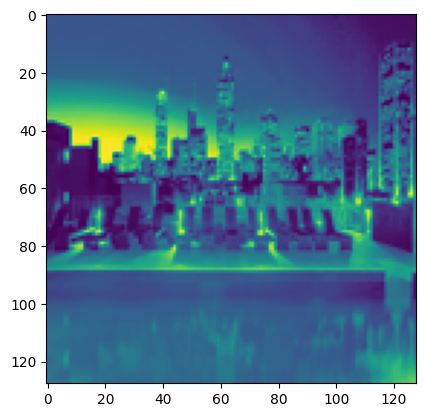

In [ ]:
# check if image preprocessing is done correctly
print("train image dimensions", x_train_image.shape)
plt.imshow(x_train_image[image_index, :, :, 0]) # plotting the same that we have seen previously to check the intended output

Now both training and testing images are ready, next we will preprocess the text data

### Text Data Preprocessing

* Since the "summary" feature contains different languages we must first translate them to a single language to be able to tokenize it properly and facilitate the learning task on the model such that each sentiment will have a corresponding single word.
* Then we will use keras tokenizer to replace each word by its index such that we pass these tokenized texts to an embedding layer when we are constructing the model
* After we tokenize the summary entries we will pad them such that all entries will have the same vector size

Importing a Translator

In [ ]:
!pip3 uninstall googletrans
!pip3 install googletrans==3.1.0a0 # needed version
from googletrans import Translator

Found existing installation: googletrans 3.1.0a0
Uninstalling googletrans-3.1.0a0:
  Would remove:
    /root/.local/bin/translate
    /root/.local/lib/python3.9/site-packages/googletrans-3.1.0a0.dist-info/*
    /root/.local/lib/python3.9/site-packages/googletrans/*
Proceed (Y/n)? Y
  Successfully uninstalled googletrans-3.1.0a0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached googletrans-3.1.0a0-py3-none-any.whl
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.0.0
    Uninstalling googletrans-3.0.0:
      Successfully uninstalled googletrans-3.0.0


Testing the translation on a single text entry to check its behaviour

In [ ]:
# original text
train_df.summary[2]

'Logement coquet et douillet à 10 minutes du centre-ville de Montréal. Épicerie, pharmacie, saq, restaurants et transports en communs à proximité. Deux chambres fermées pouvant accueillir 4 adultes!'

In [ ]:
# translating
translator = Translator()
translation = translator.translate(text =train_df.summary[2],dest='en')
translation

In [ ]:
# translated text
translation.text

'Pretty and cozy accommodation 10 minutes from downtown Montreal. Grocery store, pharmacy, saq, restaurants and public transport nearby. Two closed bedrooms that can accommodate 4 adults!'

Applying language translation on all texts as the translation is working as intended

In [ ]:
# loading summary: (force convert some of the non-string cell to string)
x_train_text = train_df.summary.astype('str')
x_test_text = test_df.summary.astype('str')


In [ ]:
# translating the training text
%%time
x_train_text_trans = x_train_text.apply(lambda summary:translator.translate(summary,dest='en').text)

CPU times: user 47.8 s, sys: 4.76 s, total: 52.6 s
Wall time: 3min 37s


In [ ]:
# translating the testing text
%%time
x_test_text_trans = x_test_text.apply(lambda summary:translator.translate(summary,dest='en').text)

CPU times: user 49.8 s, sys: 5.08 s, total: 54.9 s
Wall time: 3min 38s


Saving the translated texts variables as pickle files for later retrival if needed to avoid re-translating in case of colab runtime issues as the translation api has a maximum limit per day

In [ ]:
pickle.dump(x_train_text_trans, open("./x_train_text_trans.pck", "wb"))
pickle.dump(x_test_text_trans, open("./x_test_text_trans.pck", "wb"))

Text tokenization and padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint

vocab_size = 60000 # the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept. (max word index)
max_len = 255 # based on max of training set


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text_trans) # fitting the tokenizer on the translated training set text


def _preprocess(list_of_text):
    # padding will be done inside
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text), # tokenization (replacing words by their indicies)
        maxlen=max_len, # Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence.
        padding='post', # padding to be done at the end of the vector
        truncating='post' # will be needed in case of test set only as for training set we took the max of it (255)
    )


x_train_text_id = _preprocess(x_train_text_trans) # tokenized and padded "summary" of the training set
x_test_text_id = _preprocess(x_test_text_trans) # here we use the trained tokenizer to pre-process the testing set


In [ ]:
# without any trancation (this was done before setting a maxlen parameter in pad_sequence function to know the maximum lengths)
print(f"Training text contains {x_train_text_id.shape[0]} text entry with {x_train_text_id.shape[1]} tokens per each")
print(f"Testing text contains {x_test_text_id.shape[0]} text entry with {x_test_text_id.shape[1]} tokens per each")

Training text contains 7326 text entry with 255 tokens per each
Testing text contains 7360 text entry with 391 tokens per each


In [ ]:
# After specifing a maximum length to be able to initialize the input shape of for the input layer of the neural network
print(f"Training text contains {x_train_text_id.shape[0]} text entry with {x_train_text_id.shape[1]} tokens per each")
print(f"Testing text contains {x_test_text_id.shape[0]} text entry with {x_test_text_id.shape[1]} tokens per each")

Training text contains 7326 text entry with 255 tokens per each
Testing text contains 7360 text entry with 255 tokens per each


In [ ]:
# checking the tokenized and padded text
x_train_text_id

array([[  95,  223,    2, ...,    0,    0,    0],
       [  15,    5,   54, ...,    0,    0,    0],
       [ 549,    2,   91, ...,    0,    0,    0],
       ...,
       [  23,   10,    7, ...,    0,    0,    0],
       [  38,    7,    3, ...,    0,    0,    0],
       [ 121, 1645,  301, ...,    0,    0,    0]], dtype=int32)

In [ ]:
print('maximum possible unique words in the dictionary:', tokenizer.num_words)
print('total unique words in the dictionary:',x_train_text_id.max())

maximum possible unique words in the dictionary: 60000
total unique words in the dictionary: 9905


In [ ]:
# we can use the tokenizer to convert IDs to words.
pprint(tokenizer.sequences_to_texts(x_train_text_id[:3]), width=600) # printing a sample of the conversion

['spacious sunny and cozy modern apartment in the heart of montreal this 3 bedroom centrally located in the very popular plateau mont royal neighborhood in the middle of prince arthur pedestrian only street close to all amenities restaurants coffee house bars clubs shopping universities subway stations experience montreal like a real local resident be in the heart of the action grand prix week grill saint laurent festival mural 2019 and so much more',
 'located in one of the most vibrant and accessible locations of downtown montreal this one bedroom condo will not only impress you but leave you with one of the most memorable experiences it is walking distance of the popular sainte catherine street the bell center the old port lachine canal bonaventure metro and much much more',
 'pretty and cozy accommodation 10 minutes from downtown montreal grocery store pharmacy saq restaurants and public transport nearby two closed bedrooms that can accommodate 4 adults']


Saving the tokenized and padded texts variables as pickle files for later retrival if needed

In [ ]:
pickle.dump(x_train_text_id, open("./x_train_text_id.pck", "wb"))
pickle.dump(x_test_text_id, open("./x_test_text_id.pck", "wb"))

loading the tokenized and padded texts as a runtime issue has occured as expected

In [ ]:
x_train_text_id = pickle.load(open("./x_train_text_id.pck", "rb")) # training text vector
x_test_text_id = pickle.load(open("./x_test_text_id.pck", "rb")) # testing text vector

## **5- Building Learning Models, Training and Evaluation 📈**
* All the models that will be tried will be multi-modal and multi-task models in which we will use both text and images data to predict the price and apartmnent type
* Will first fix the text modality model part and experiment with different CNNs then we will fix the best obtained CNN and try different modeling for input text

Define model metrics visualization function such as accuracy and validation versus epoch, to be used to visualize each tried model performance

In [ ]:
def model_history_plot(history):
    print(history.history.keys())

    price_tr_accuracy= history.history['price_catg_sparse_categorical_accuracy']
    price_val_accuracy= history.history['val_price_catg_sparse_categorical_accuracy']

    price_tr_loss= history.history['price_catg_loss']
    price_val_loss= history.history['val_price_catg_loss']

    type_tr_accuracy= history.history['aprt_type_sparse_categorical_accuracy']
    type_val_accuracy= history.history['val_aprt_type_sparse_categorical_accuracy']

    type_tr_loss= history.history['aprt_type_loss']
    type_val_loss= history.history['val_aprt_type_loss']

    learning_rate = history.history['lr']

    epochs = len(price_tr_accuracy)+1

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    plt.subplots_adjust(wspace=1.2)

    ax2 = fig.add_subplot(131)
    plt.title(f"Training and Validation Accuracy VS Epochs (Price)")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1, epochs), price_val_accuracy, label="validation accuracy (Price)")
    plt.plot(np.arange(1,epochs), price_tr_accuracy, label = "training accuracy (Price)")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper left")

    ax2_t = ax2.twinx()
    ax2_t.plot(np.arange(1,epochs), learning_rate, 'o:r', label = "lr", alpha=0.2)
    plt.ylabel('Learning Rate')
    plt.legend(bbox_to_anchor=(1.2, 0.85), loc="upper left")

    ax1 = fig.add_subplot(132)
    plt.title(f"Training and Validation Loss VS Epochs (Price)")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(np.arange(1,epochs), price_val_loss, label="validation loss (Price)")
    plt.plot(np.arange(1,epochs), price_tr_loss, label = "training loss (Price)")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()
    print("\n")

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    plt.subplots_adjust(wspace=1)

    ax3 = fig.add_subplot(131)
    plt.title(f"Training and Validation Accuracy VS Epochs (Type)")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1, epochs), type_val_accuracy, label="validation accuracy (Type)")
    plt.plot(np.arange(1,epochs), type_tr_accuracy, label = "training accuracy (Type)")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

    ax4 = fig.add_subplot(132)
    plt.title(f"Training and Validation Loss VS Epochs (Type)")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(np.arange(1,epochs), type_val_loss, label="validation loss (Type)")
    plt.plot(np.arange(1,epochs), type_tr_loss, label = "training loss (Type)")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

    plt.show()

### Model 1 (Simple CNN and simple Text Embedding) ⭐⭐⭐
We start our first trail by a simple model
* for text modality we will use simple embedding function such that for each vector we will project each of its tokens to a 255 dimension space (specified by code) then we will get a mean value for each token which is the avearge of its projections across the 255-dimensions
* for image modality we will use a simple CNN architetcure, we will just use 2 CNN layers of relu activation function and each is followed by a maxpooling layer then we faltten the output of the last maxpooling layer
* Finally we will concatenate the embedding averages vetcor with the images flatten vector to get single fused vector that will be passed to 2 dense layers of softmax activation functions. One layer for price prediction and the other for type prediction.
* below figure summarizes the used model architecture

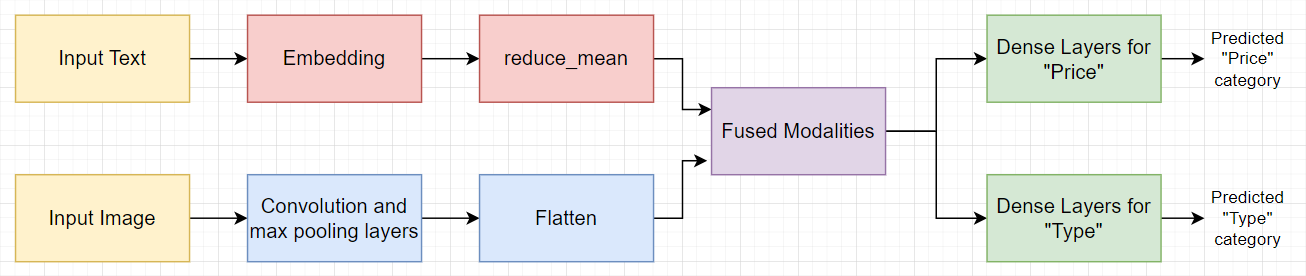

Model 1 Architecture

Thoughts before trial
* Since we are using a simple model we expect the model to be underfitting as the convolutional layer which is responsible for features extraction is not complex also the fully connected layer network which is responsible for decission boundaries and prediction is also simple so we expect some what underfitting

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout, Lambda, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None,max_len)) # None is batch size
in_image = keras.Input(batch_shape=(None, 128, 128, 2))

# text part
# Embedding(Size of the vocabulary i.e. maximum integer index + 1, Dimension of the dense embedding, Length of input sequences)
embedded = keras.layers.Embedding(input_dim = (x_train_text_id.max()+1), # number of unique words in the dictionary (model vocabulary) -> 9905 + 1
                                  output_dim = x_train_text_id.shape[1], # 255 tokens (based on training text)
                                  input_length = max_len, # 255
                                  )(in_text)
# the output of Embedding layer is (None,255,255) which is None(batch size), 255 (input length of "each word") x 255 (Dimension of the dense embedding "word" projection value for each axis)

# simple average of embedding of each word
averaged = tf.reduce_mean(embedded, axis=1) # function not a layer so there is no ()
# the output is (None,255) which is 1D vector, so this operation has an effect of flattening


# image part
# simple conv2d.

# number of parameters of each convolutional layer --> (kernel_width * kernel_height * num_filters * num_input_channels) + num_of_filters

cov1 = Conv2D(filters = 6, kernel_size=(3, 3), strides=(1,1), padding='same' )(in_image) # 128x128x6  --> [128 + 2(1) - 3 / 1] + 1 = 128 --> 128x128
actv1 = Activation('relu')(cov1)
pl1 = MaxPool2D((2, 2))(actv1) # 64x64x6   --> [128 + 2(0)-2 / 2 ] + 1 = 64 --> 64x64 note stride of pooling is by default the same as th kernel dimension

cov2 = Conv2D(filters = 32, kernel_size=(16, 16), strides=(1,1), padding='valid' )(pl1) # 49x49x32  --> [64 + 2(0) - 16 / 1] + 1 = 49 --> 49x49
actv2 = Activation('relu')(cov2)
pl2 = MaxPool2D((16, 16))(actv2) # 3x3x32   --> [49 + 2(0)-16 / 16 ] + 1 = 3.06 --> 3x3 note stride of pooling is by default the same as th kernel dimension

flattened = Flatten()(pl2) # 288


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1) # Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
# 255(text vector) + 288 (image vector) = 543


# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(units=len_aprt_type, activation='softmax', name='aprt_type')(fused)
p_price = Dense(units=len_price_categ, activation='softmax', name='price_catg')(fused)


# define model input/output using keys.
model_1 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'aprt_type': p_type,
        'price_catg': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model_1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'aprt_type': 'sparse_categorical_crossentropy',
        'price_catg': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'aprt_type': 0.5,
        'price_catg': 0.5,  # the higher the value the more to focus on it
    },
    metrics={
        'aprt_type': ['SparseCategoricalAccuracy'],
        'price_catg': ['SparseCategoricalAccuracy'],
    },
)

model_1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 6)  114         ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 128, 6)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 6)    0           ['activation[0][0]']         

Model 1 Training

In [ ]:
%%time
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_price_catg_loss', patience=3, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_price_catg_loss',
                                patience=2,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.01,
                                min_lr=1e-6)

history_1 = model_1.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'aprt_type': y_train_type,
        'price_catg': y_train_price,
    },
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop_callback, lr_reduction],
    verbose=1
)


Epoch 1/20
184/184 [==============================] - 44s 181ms/step - loss: 2.7489 - aprt_type_loss: 3.0068 - price_catg_loss: 2.4911 - aprt_type_sparse_categorical_accuracy: 0.6863 - price_catg_sparse_categorical_accuracy: 0.5471 - val_loss: 1.0040 - val_aprt_type_loss: 1.0737 - val_price_catg_loss: 0.9344 - val_aprt_type_sparse_categorical_accuracy: 0.7585 - val_price_catg_sparse_categorical_accuracy: 0.6132 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 13s 72ms/step - loss: 0.9822 - aprt_type_loss: 1.0769 - price_catg_loss: 0.8876 - aprt_type_sparse_categorical_accuracy: 0.7538 - price_catg_sparse_categorical_accuracy: 0.5860 - val_loss: 0.9599 - val_aprt_type_loss: 1.0435 - val_price_catg_loss: 0.8763 - val_aprt_type_sparse_categorical_accuracy: 0.7667 - val_price_catg_sparse_categorical_accuracy: 0.6098 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 5s 28ms/step - loss: 0.9268 - aprt_type_loss: 1.0238 - price_catg_loss: 0.8299 - aprt_type_

KeyError: ignored

dict_keys(['loss', 'aprt_type_loss', 'price_catg_loss', 'aprt_type_sparse_categorical_accuracy', 'price_catg_sparse_categorical_accuracy', 'val_loss', 'val_aprt_type_loss', 'val_price_catg_loss', 'val_aprt_type_sparse_categorical_accuracy', 'val_price_catg_sparse_categorical_accuracy', 'lr'])


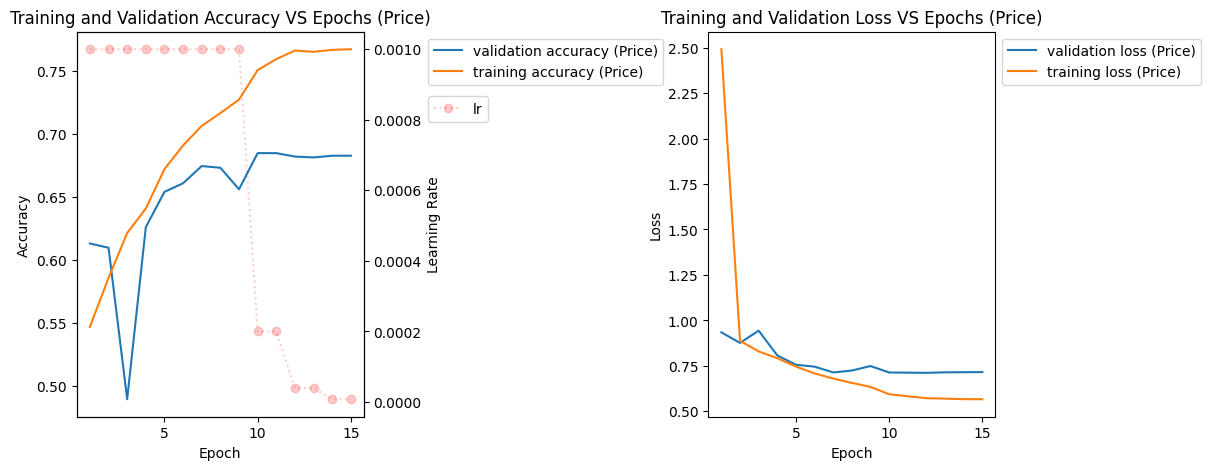

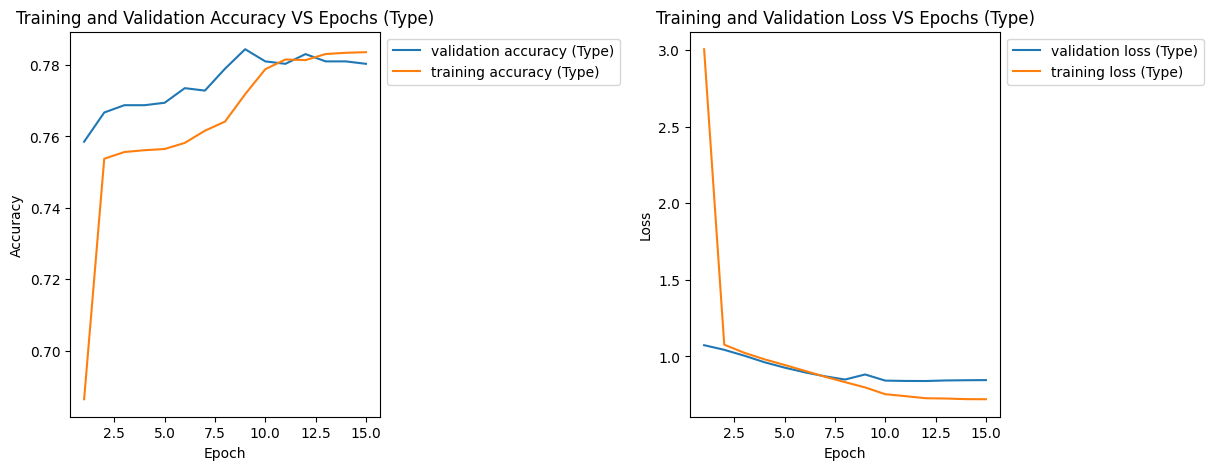

In [ ]:
model_history_plot(history_1)

Model 1 Predictions

In [ ]:
# we can do prediction on training set
y_predict = model_1.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)

230/230 [==============================] - 2s 6ms/step


In [ ]:
# Predicted Price

# probabilities
price_predicted = y_predict['price_catg']
print(price_predicted,"\n")
# categories
price_category_predicted = np.argmax(price_predicted, axis=1) # agrmax -> index of max value
print(price_category_predicted, "\n")
print(np.unique(price_category_predicted, return_counts=True))

[[0.73717    0.21725497 0.04557506]
 [0.88991606 0.09190992 0.018174  ]
 [0.80945814 0.14872135 0.04182054]
 ...
 [0.88452333 0.09391002 0.02156669]
 [0.9720811  0.02251241 0.00540638]
 [0.7584277  0.1652363  0.07633609]]
[0 0 0 ... 0 0 0]


In [ ]:
np.unique(price_category_predicted, return_counts=True)

(array([0, 1, 2]), array([5443, 1898,   19]))

In [ ]:
# Predicted Type

# probabilities
type_predicted = y_predict['aprt_type']
print(type_predicted,"\n")
# categories
type_category_predicted = np.argmax(type_predicted, axis=1) # agrmax -> index of max value
print(type_category_predicted, "\n")
print(np.unique(type_category_predicted, return_counts=True))

[[7.5657904e-04 6.4350444e-01 1.2532345e-02 ... 1.1555958e-03
  3.9704826e-02 4.1323788e-03]
 [1.0451957e-04 8.5158455e-01 5.6680250e-03 ... 8.4791385e-04
  9.1364682e-03 2.0734118e-03]
 [7.7969924e-04 5.1038170e-01 7.5593675e-03 ... 6.5364147e-04
  5.3301040e-02 1.6017335e-03]
 ...
 [1.0093665e-03 7.4695981e-01 3.3928487e-03 ... 2.7004792e-04
  2.5672024e-02 1.3987581e-03]
 [3.1019244e-04 6.7380494e-01 1.0685072e-02 ... 2.5219584e-03
  3.9263215e-02 1.7301291e-03]
 [1.2258518e-03 7.9384047e-01 4.6068323e-03 ... 1.8402081e-04
  1.9537838e-02 1.7024623e-03]] 

[1 1 1 ... 1 1 1] 

(array([ 1, 10, 15, 17, 18, 20]), array([7153,  136,    3,   41,   23,    4]))


Thoughts after trial
* from the convergence curves of the trial we can notice that for the "Price" label there is a gap between the training accuracy and the validation accuracy which can somehow propose that the model is overfitting however I am not totally sure as the observed performance on the training set is not that good either. I have been in this uncertainity usually when I start with simple models so I guess we must usually start with a very complex model and overfit the data to be sure that the problem is solvable and then simplify the model till it can generalize, otherwise we can not decide from the simple model performance. However for now if we took the performance on the leaderboard as our reference we can deduce that the model is overfitting so in the next model we will introduce a dropout layer to tackle this issue.
* However if we looked at the convergence curves of the "Type" label we can notice that the model is fitting it appropriately.
* Testing Accuracy on Kaggle: 0.67989 (Best Result)

Model 1 Submission

In [ ]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test_df.id,
     'price': price_category_predicted}
).to_csv('model_1_submission.csv', index=False)

### Model 2 (Simple CNN and simple Text Embedding with Dropout)
We suspected that maybe our first trail was overfitting so we introduced a dropout layer in the image modality handeling part. text modality sequence of operations was not changed.
Change in image modality path will be as follows:

* We will use 2 CNN layers of relu activation function and each is followed by a maxpooling layer as before but insert a dropout layer just after the first maxpooling layer. We then faltten the output of the last maxpooling layer
* Rest of model connections will remain the same
* New model will follow below figure except for the added dropout layer in the convolution layers block

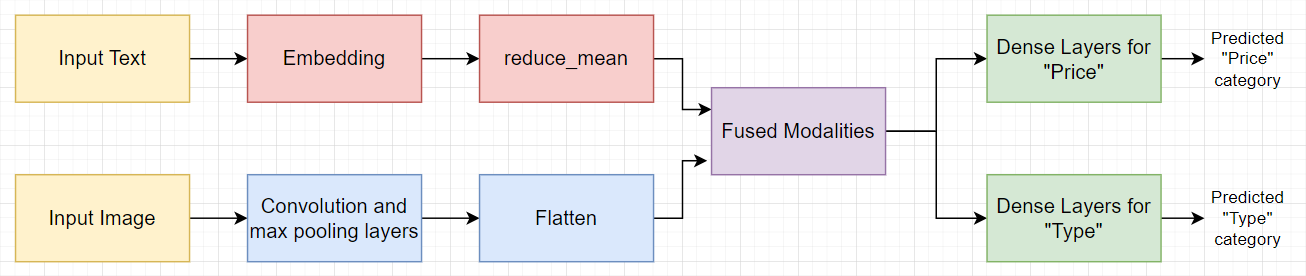

Model 2 Architecture

Thoughts before trial

* Since we introduced the dropout layer we expect the model to be better at generalization and doesn't suffer from potential overfitting however the dropout layer can have a negative effect as it is introduced between the convolutional layers it can affect the obtained features.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout, Lambda, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None,max_len)) # None is batch size
in_image = keras.Input(batch_shape=(None, 128, 128, 2))

# text part
# Embedding(Size of the vocabulary i.e. maximum integer index + 1, Dimension of the dense embedding, Length of input sequences)
embedded = keras.layers.Embedding(input_dim = (x_train_text_id.max()+1), # number of unique words in the dictionary (model vocabulary) -> 9905 + 1
                                  output_dim = x_train_text_id.shape[1], # 255 tokens (based on training text)
                                  input_length = max_len, # 255
                                  )(in_text)
# the output of Embedding layer is (None,255,255) which is None(batch size), 255 (input length of "each word") x 255 (Dimension of the dense embedding "word" projection value for each axis)

# simple average of embedding of each word
averaged = tf.reduce_mean(embedded, axis=1) # function not a layer so there is no ()
# the output is (None,255) which is 1D vector, so this operation has an effect of flattening


# image part
# simple conv2d.

# number of parameters of each convolutional layer --> (kernel_width * kernel_height * num_filters * num_input_channels) + num_of_filters


cov1 = Conv2D(filters = 6, kernel_size=(3, 3), strides=(1,1), padding='same' )(in_image) # 128x128x6  --> [128 + 2(1) - 3 / 1] + 1 = 128 --> 128x128
actv1 = Activation('relu')(cov1)
pl1 = MaxPool2D((2, 2))(actv1) # 64x64x6   --> [128 + 2(0)-2 / 2 ] + 1 = 64 --> 64x64 note stride of pooling is by default the same as th kernel dimension

drop1 = Dropout(rate = 0.1)(pl1)

cov2 = Conv2D(filters = 32, kernel_size=(16, 16), strides=(1,1), padding='valid' )(drop1) # 49x49x32  --> [64 + 2(0) - 16 / 1] + 1 = 49 --> 49x49
actv2 = Activation('relu')(cov2)
pl2 = MaxPool2D((16, 16))(actv2) # 3x3x32   --> [49 + 2(0)-16 / 16 ] + 1 = 3.06 --> 3x3 note stride of pooling is by default the same as th kernel dimension

flattened = Flatten()(pl2) # 288


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1) # Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
# 255(text vector) + 36 (image vector) = 383


# multi-task learning (each is a multi-class classification)
# one dense layer for each task


p_type = Dense(units=len_aprt_type, activation='softmax', name='aprt_type')(fused)
p_price = Dense(units=len_price_categ, activation='softmax', name='price_catg')(fused)


# define model input/output using keys.
model_2 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'aprt_type': p_type,
        'price_catg': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model_2.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'aprt_type': 'sparse_categorical_crossentropy',
        'price_catg': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'aprt_type': 0.5,
        'price_catg': 0.5,  # the higher the value the more to focus on it
    },
    metrics={
        'aprt_type': ['SparseCategoricalAccuracy'],
        'price_catg': ['SparseCategoricalAccuracy'],
    },
)

model_2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 6)  114         ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 128, 6)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 6)    0           ['activation[0][0]']         

Model 2 Training

In [ ]:
import gc
del model_2
tf.keras.backend.clear_session()
gc.collect()

In [ ]:
%%time
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_price_catg_loss', patience=5, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_price_catg_loss',
                                patience=3,
                                verbose=1,
                                factor=0.5,
                                min_delta = 0.001,
                                min_lr=1e-7)

history_2 = model_2.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'aprt_type': y_train_type,
        'price_catg': y_train_price,
    },
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop_callback, lr_reduction],
    verbose=1
)


Epoch 1/20
184/184 [==============================] - 38s 143ms/step - loss: 5.2948 - aprt_type_loss: 5.9520 - price_catg_loss: 4.6377 - aprt_type_sparse_categorical_accuracy: 0.6483 - price_catg_sparse_categorical_accuracy: 0.5232 - val_loss: 0.9130 - val_aprt_type_loss: 1.0037 - val_price_catg_loss: 0.8224 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 14s 74ms/step - loss: 0.9157 - aprt_type_loss: 1.0032 - price_catg_loss: 0.8282 - aprt_type_sparse_categorical_accuracy: 0.7560 - price_catg_sparse_categorical_accuracy: 0.6186 - val_loss: 0.8827 - val_aprt_type_loss: 0.9498 - val_price_catg_loss: 0.8157 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 8s 40ms/step - loss: 0.9011 - aprt_type_loss: 0.9839 - price_catg_loss: 0.8183 - aprt_type_

dict_keys(['loss', 'aprt_type_loss', 'price_catg_loss', 'aprt_type_sparse_categorical_accuracy', 'price_catg_sparse_categorical_accuracy', 'val_loss', 'val_aprt_type_loss', 'val_price_catg_loss', 'val_aprt_type_sparse_categorical_accuracy', 'val_price_catg_sparse_categorical_accuracy', 'lr'])


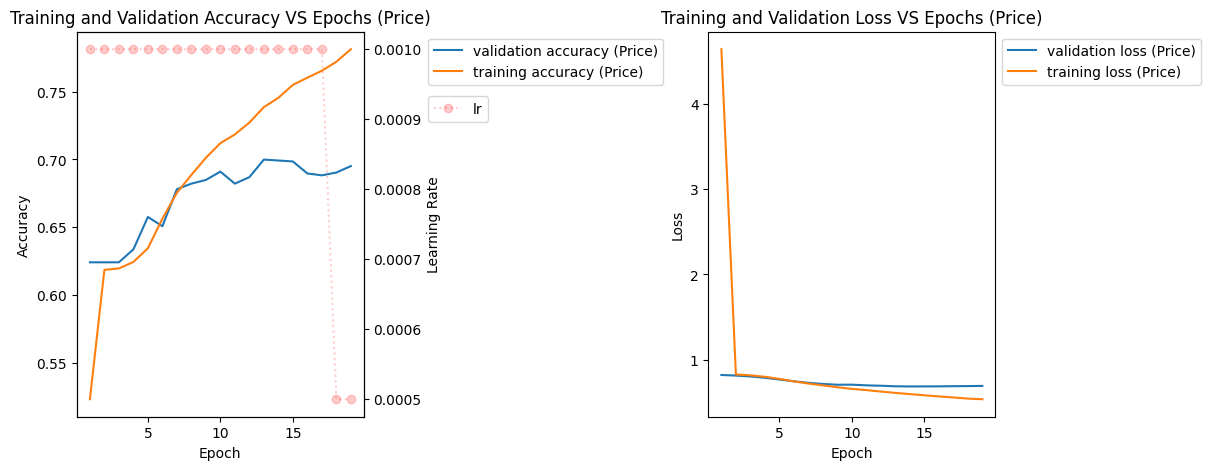

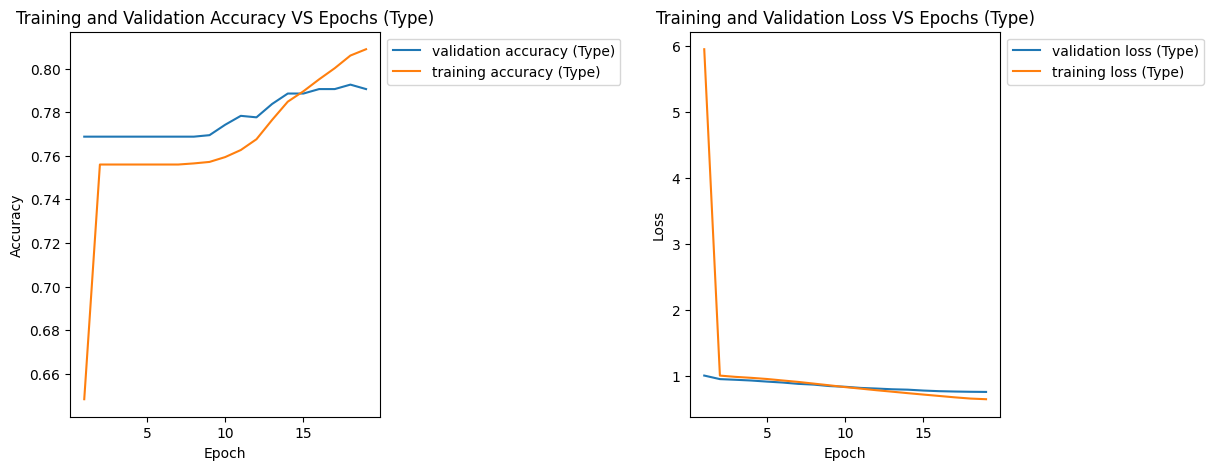

In [ ]:
model_history_plot(history_2)

Model 2 Predictions

In [ ]:
# we can do prediction on training set
y_predict = model_2.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)

230/230 [==============================] - 1s 4ms/step


In [ ]:
# Predicted Price

# probabilities
price_predicted = y_predict['price_catg']
print(price_predicted,"\n")
# categories
price_category_predicted = np.argmax(price_predicted, axis=1) # agrmax -> index of max value
print(price_category_predicted, "\n")
print(np.unique(price_category_predicted, return_counts=True))

[[0.8345931  0.13386536 0.03154155]
 [0.9155733  0.06985343 0.01457328]
 [0.8963862  0.07484492 0.02876886]
 ...
 [0.85625684 0.12272119 0.02102204]
 [0.9802358  0.01525566 0.00450853]
 [0.80716395 0.16772364 0.02511241]] 

[0 0 0 ... 0 0 0] 

(array([0, 1, 2]), array([5796, 1544,   20]))


In [ ]:
# Predicted Type

# probabilities
type_predicted = y_predict['aprt_type']
print(type_predicted,"\n")
# categories
type_category_predicted = np.argmax(type_predicted, axis=1) # agrmax -> index of max value
print(type_category_predicted, "\n")
print(np.unique(type_category_predicted, return_counts=True))

[[6.8701676e-04 5.4210746e-01 8.7021329e-03 ... 1.0345797e-03
  5.6507774e-02 1.7376901e-03]
 [8.9830712e-05 8.9165658e-01 2.3571709e-03 ... 1.9938064e-04
  1.3679350e-02 3.2783946e-04]
 [9.6388801e-04 3.7530494e-01 1.0849084e-02 ... 1.2564764e-03
  7.8709416e-02 2.2184737e-03]
 ...
 [1.9725236e-04 7.9534906e-01 3.7556051e-03 ... 3.4926474e-04
  2.4014203e-02 5.6359544e-04]
 [1.8713834e-04 7.4317211e-01 6.5023112e-03 ... 6.0496060e-04
  3.6604926e-02 1.1128499e-03]
 [1.2868496e-04 8.0298787e-01 2.7630862e-03 ... 2.8907548e-04
  1.5615984e-02 4.7191689e-04]] 

[1 1 1 ... 1 1 1] 

(array([ 0,  1, 10, 17, 18, 20]), array([   1, 7007,  160,  141,   40,   11]))


Thoughts after trial
* from the convergence curves of the trial we can notice that for the "Price" label the performance is very close from the previous trail
* However the testing accuracy on Kaggle is: 0.67934 which is less than the best obatined values which was 0.67989 but the difference is very small, this difference may has risen due to the features that have been dropped but it seems that they were not very important.
* Next will keep the text path as it is as this trial and the previous one but will instead continue at investigating the effect of the convolutional layers path. Specifically we will be implementing the LeNet5 architecture to try to obtain more features from the images than the ones we are obtaining by this simple CNN layer. Hopefully the newly obtained features will be beneficial for model training.

Model 2 Submission

In [ ]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test_df.id,
     'price': price_category_predicted}
).to_csv('model_2_submission.csv', index=False)

### Model 3 (LeNet 5 CNN and Simple Text Embedding)
* In this trial for image modality we will use LeNet-5 achritecture in aim of obtaining more features from the images. For the text modality we will use the same path that was used before which was a simple embedding function and its mean.


Model 3 Architecture

Thoughts before trial:
* we expect this model to be better than the previous ones as we are obtaining more features for the model to learn from so it has a potential to be able to generalize well

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout, Lambda, Activation, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None,max_len)) # None is batch size
in_image = keras.Input(batch_shape=(None, 128, 128, 2))

# text part
# Embedding(Size of the vocabulary i.e. maximum integer index + 1, Dimension of the dense embedding, Length of input sequences)
embedded = keras.layers.Embedding(input_dim = (x_train_text_id.max()+1), # number of unique words in the dictionary (model vocabulary) -> 9905 + 1
                                  output_dim = x_train_text_id.shape[1], # 255 tokens (based on training text)
                                  input_length = max_len, # 255
                                  )(in_text)
# the output of Embedding layer is (None,255,255) which is None(batch size), 255 (input length of "each word") x 255 (Dimension of the dense embedding "word" projection value for each axis)

# simple average of embedding of each word
averaged = tf.reduce_mean(embedded, axis=1) # function not a layer so there is no ()
# the output is (None,255) which is 1D vector, so this operation has an effect of flattening


# image part
# LeNet5 Architecture

# number of parameters of each convolutional layer --> (kernel_width * kernel_height * num_filters * num_input_channels) + num_of_filters

# Resize input image to be 32x32 to be same as the model design
in_image_resz = Lambda(lambda x: tf.compat.v1.image.resize_images(x, (32, 32)), input_shape=(128,128,2))(in_image)

# 1st Convolutional Layer
conv1 = Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid')(in_image_resz) # C1 28x28x6
actv1 = Activation('tanh')(conv1)
pl1 = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(actv1) # S2 14x14x6

# 2nd Convolutional Layer
conv2 = Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid')(pl1) # C3 10x10x16
actv2 = Activation('tanh')(conv2)
pl2 = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(actv2) # S4 5x5x16

# 3rd Convolutional Layer
conv3 = Conv2D(filters=120, kernel_size=(5,5), strides=(1,1), padding='valid')(pl2) # C5 1x1x120
actv3 = Activation('tanh')(conv3)

# Passing it to a Fully Connected layer
flattened = Flatten()(actv3) # 120


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1) # Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
# 255(text vector) + 120 (image vector) = 375


# multi-task learning (each is a multi-class classification)
# two dense layers for each task


# 1st Fully Connected Layer
dense1 = Dense(units = 84,activation = 'tanh')(fused) # F6

# 2nd Fully Connected Layer (output layer)
p_type = Dense(units=len_aprt_type, activation='softmax', name='aprt_type')(dense1)
p_price = Dense(units=len_price_categ, activation='softmax', name='price_catg')(dense1)


# define model input/output using keys.
model_3 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'aprt_type': p_type,
        'price_catg': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model_3.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'aprt_type': 'sparse_categorical_crossentropy',
        'price_catg': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'aprt_type': 0.5,
        'price_catg': 0.5,  # the higher the value the more to focus on it
    },
    metrics={
        'aprt_type': ['SparseCategoricalAccuracy'],
        'price_catg': ['SparseCategoricalAccuracy'],
    },
)

model_3.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 2)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 6)    306         ['lambda[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 28, 28, 6)    0           ['conv2d[0][0]']             

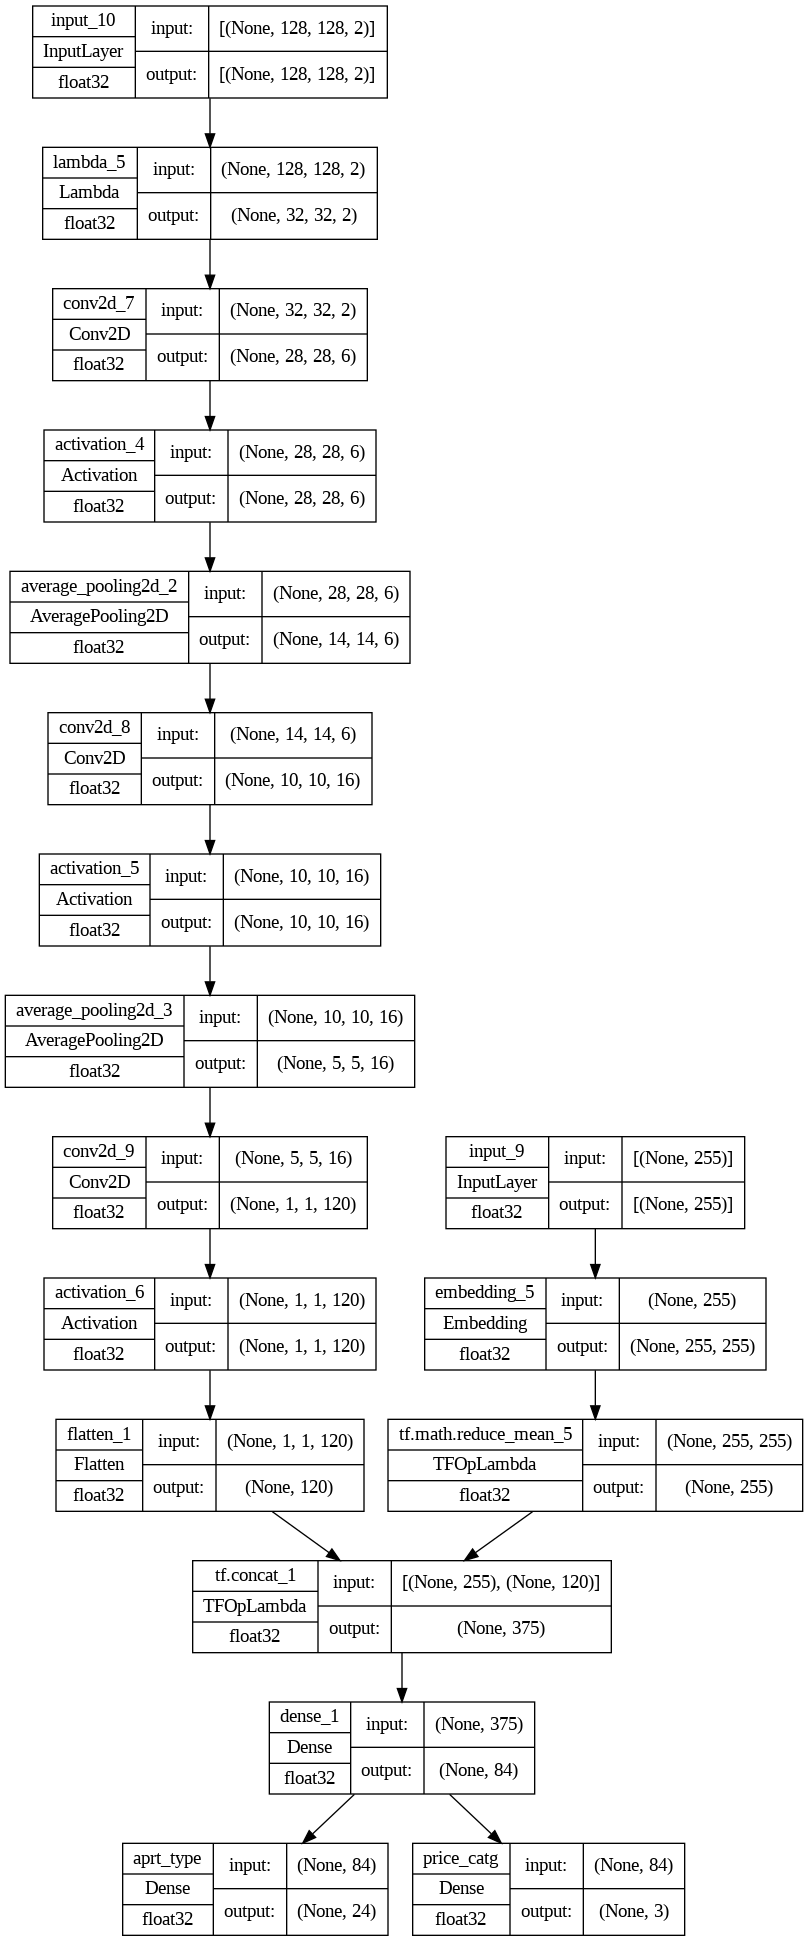

In [ ]:
tf.keras.utils.plot_model(model_3, show_shapes=True, show_dtype=True)

Model 3 Training

In [ ]:
import gc
del model_3
tf.keras.backend.clear_session()
gc.collect()

20392

In [ ]:
%%time
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_price_catg_loss', patience=10, start_from_epoch = 5)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_price_catg_loss',
                                patience=3,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-7)

history_3 = model_3.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'aprt_type': y_train_type,
        'price_catg': y_train_price,
    },
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop_callback, lr_reduction],
    verbose=1
)


Epoch 1/20
184/184 [==============================] - 23s 108ms/step - loss: 0.9628 - aprt_type_loss: 1.0706 - price_catg_loss: 0.8550 - aprt_type_sparse_categorical_accuracy: 0.7519 - price_catg_sparse_categorical_accuracy: 0.6080 - val_loss: 0.8949 - val_aprt_type_loss: 0.9631 - val_price_catg_loss: 0.8268 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 8s 43ms/step - loss: 0.9244 - aprt_type_loss: 1.0150 - price_catg_loss: 0.8338 - aprt_type_sparse_categorical_accuracy: 0.7560 - price_catg_sparse_categorical_accuracy: 0.6200 - val_loss: 0.8860 - val_aprt_type_loss: 0.9674 - val_price_catg_loss: 0.8046 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 7s 37ms/step - loss: 0.8887 - aprt_type_loss: 0.9992 - price_catg_loss: 0.7782 - aprt_type_s

dict_keys(['loss', 'aprt_type_loss', 'price_catg_loss', 'aprt_type_sparse_categorical_accuracy', 'price_catg_sparse_categorical_accuracy', 'val_loss', 'val_aprt_type_loss', 'val_price_catg_loss', 'val_aprt_type_sparse_categorical_accuracy', 'val_price_catg_sparse_categorical_accuracy', 'lr'])


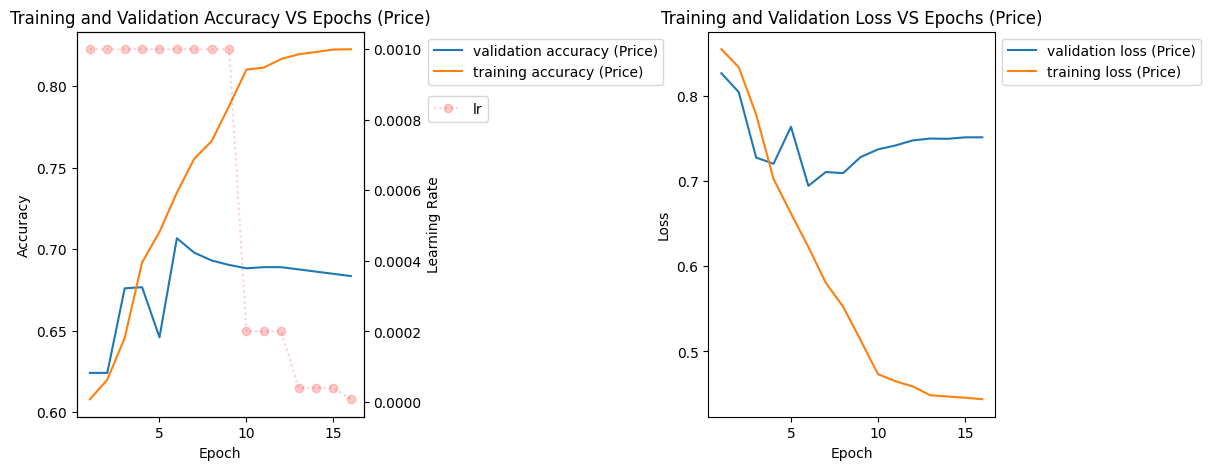

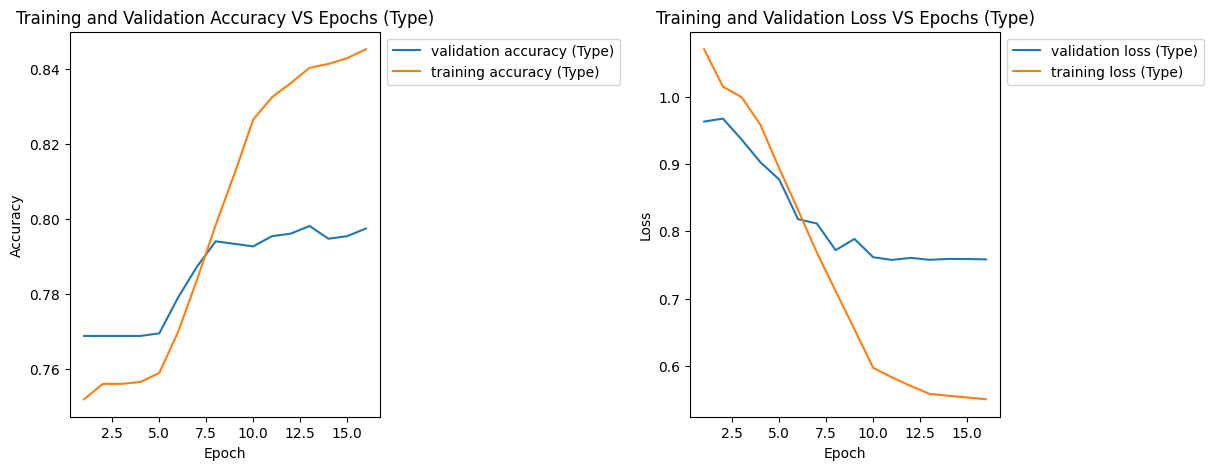

In [ ]:
model_history_plot(history_3)

Model 3 Predictions

In [ ]:
# we can do prediction on training set
y_predict = model_3.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)

230/230 [==============================] - 1s 4ms/step


In [ ]:
# Predicted Price

# probabilities
price_predicted = y_predict['price_catg']
print(price_predicted,"\n")
# categories
price_category_predicted = np.argmax(price_predicted, axis=1) # agrmax -> index of max value
print(price_category_predicted, "\n")
print(np.unique(price_category_predicted, return_counts=True))

[[8.16819906e-01 1.49597377e-01 3.35826986e-02]
 [9.70758677e-01 2.66897418e-02 2.55159196e-03]
 [9.69859540e-01 2.36786567e-02 6.46182755e-03]
 ...
 [8.78576159e-01 1.07790262e-01 1.36336461e-02]
 [9.99160051e-01 7.90826569e-04 4.90732455e-05]
 [8.82930338e-01 1.08280525e-01 8.78921244e-03]] 

[0 0 0 ... 0 0 0] 

(array([0, 1, 2]), array([5023, 2296,   41]))


In [ ]:
# Predicted Type

# probabilities
type_predicted = y_predict['aprt_type']
print(type_predicted,"\n")
# categories
type_category_predicted = np.argmax(type_predicted, axis=1) # agrmax -> index of max value
print(type_category_predicted, "\n")
print(np.unique(type_category_predicted, return_counts=True))

[[2.6584594e-03 2.0683058e-01 1.7474471e-02 ... 3.7615113e-03
  1.2989101e-01 5.1043467e-03]
 [4.5182005e-05 9.2219037e-01 3.6997041e-03 ... 4.5921802e-04
  8.5016489e-03 3.8592020e-04]
 [1.2693858e-03 7.2916687e-02 1.3972743e-02 ... 2.9445770e-03
  1.5309866e-01 3.4751461e-03]
 ...
 [3.5516272e-04 7.6835418e-01 8.1441393e-03 ... 1.2662866e-03
  2.7603079e-02 1.3571100e-03]
 [4.3576143e-05 7.0203269e-01 1.3780030e-02 ... 1.6878558e-03
  3.6553461e-02 1.1799365e-03]
 [9.5842646e-05 8.0225843e-01 4.1696955e-03 ... 6.0882815e-04
  8.1641627e-03 6.1732659e-04]] 

[17  1 17 ...  1  1  1] 

(array([ 0,  1, 10, 15, 17, 18, 20, 22]), array([   1, 6517,  350,    9,  354,  104,   23,    2]))


Thoughts after trial:
* we can see that the model performance on the training set has increased but the model is clearly overfitting so we are moving in the right direction however we need to introduce some regularization so we will add dropout layers to prevent the overfitting.
* Testing accuracy on Kaggle: 0.67146

Model 3 Submission

In [ ]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test_df.id,
     'price': price_category_predicted}
).to_csv('model_3_submission.csv', index=False)

### Model 4 (LeNet 5 CNN and Simple Text Embedding with Dropout)
This model architecture is the same as the previous model 3 however we added 2 dropout layers one after we get the fused vector and another one after the first fully connected layer.

Model 4 Architecture

Thoughts before trial:
* we think that the usage of dropout layers will reduce the overfitting and the model will be balanced between using the obtained new features by LeNet5 but also not overfitting.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 2)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 6)    306         ['lambda[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 28, 28, 6)    0           ['conv2d[0][0]']             

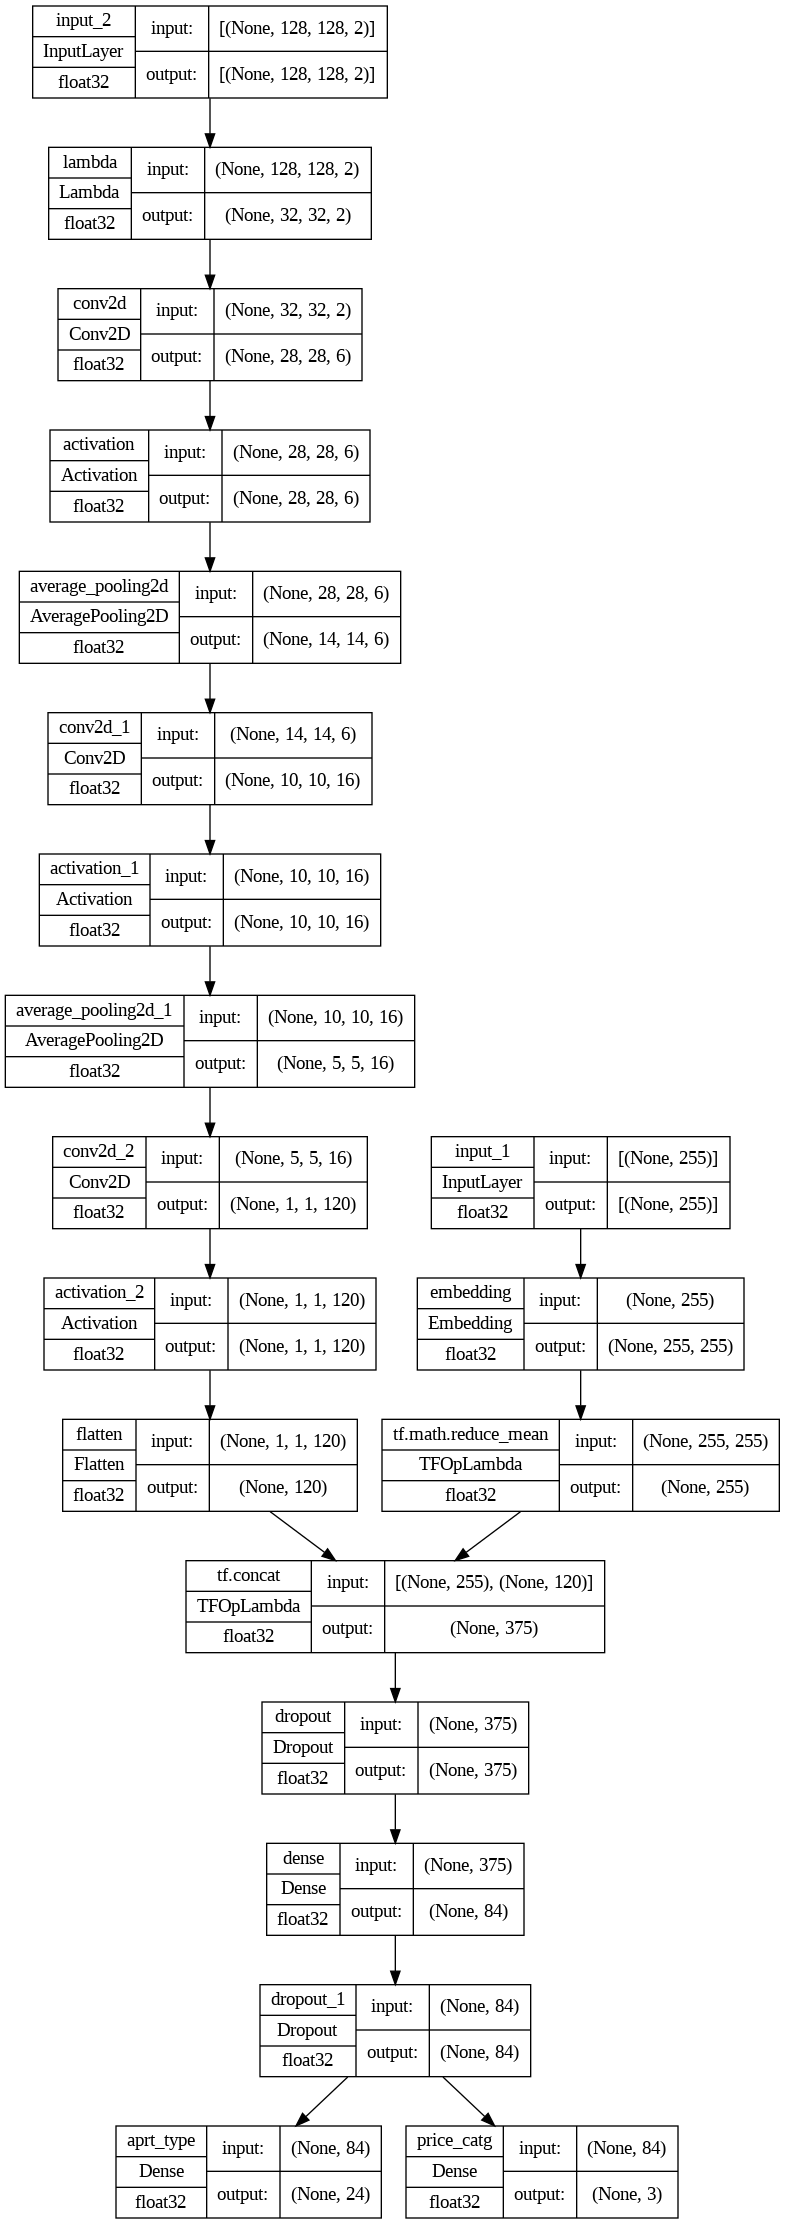

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout, Lambda, Activation, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None,max_len)) # None is batch size
in_image = keras.Input(batch_shape=(None, 128, 128, 2))

# text part
# Embedding(Size of the vocabulary i.e. maximum integer index + 1, Dimension of the dense embedding, Length of input sequences)
embedded = keras.layers.Embedding(input_dim = (x_train_text_id.max()+1), # number of unique words in the dictionary (model vocabulary) -> 9905 + 1
                                  output_dim = x_train_text_id.shape[1], # 255 tokens (based on training text)
                                  input_length = max_len, # 255
                                  )(in_text)
# the output of Embedding layer is (None,255,255) which is None(batch size), 255 (input length of "each word") x 255 (Dimension of the dense embedding "word" projection value for each axis)

# simple average of embedding of each word
averaged = tf.reduce_mean(embedded, axis=1) # function not a layer so there is no ()
# the output is (None,255) which is 1D vector, so this operation has an effect of flattening


# image part
# LeNet5 Architecture

# number of parameters of each convolutional layer --> (kernel_width * kernel_height * num_filters * num_input_channels) + num_of_filters

# Resize input image to be 32x32 to be same as the model design
in_image_resz = Lambda(lambda x: tf.compat.v1.image.resize_images(x, (32, 32)), input_shape=(128,128,2))(in_image)

# 1st Convolutional Layer
conv1 = Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid')(in_image_resz) # C1 28x28x6
actv1 = Activation('tanh')(conv1)
pl1 = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(actv1) # S2 14x14x6

# 2nd Convolutional Layer
conv2 = Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid')(pl1) # C3 10x10x16
actv2 = Activation('tanh')(conv2)
pl2 = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(actv2) # S4 5x5x16

# 3rd Convolutional Layer
conv3 = Conv2D(filters=120, kernel_size=(5,5), strides=(1,1), padding='valid')(pl2) # C5 1x1x120
actv3 = Activation('tanh')(conv3)

# Passing it to a Fully Connected layer
flattened = Flatten()(actv3) # 120


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1) # Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
# 255(text vector) + 120 (image vector) = 375

dropout1 = Dropout(rate = 0.30)(fused)

# multi-task learning (each is a multi-class classification)
# two dense layers for each task


# 1st Fully Connected Layer
dense1 = Dense(units = 84,activation = 'tanh')(dropout1) # F6
dropout2 = Dropout(rate = 0.50)(dense1)

# 2nd Fully Connected Layer
p_type = Dense(units=len_aprt_type, activation='softmax', name='aprt_type')(dropout2)
p_price = Dense(units=len_price_categ, activation='softmax', name='price_catg')(dropout2)


# define model input/output using keys.
model_4 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'aprt_type': p_type,
        'price_catg': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model_4.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'aprt_type': 'sparse_categorical_crossentropy',
        'price_catg': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'aprt_type': 0.5,
        'price_catg': 0.5,  # the higher the value the more to focus on it
    },
    metrics={
        'aprt_type': ['SparseCategoricalAccuracy'],
        'price_catg': ['SparseCategoricalAccuracy'],
    },
)

model_4.summary()
tf.keras.utils.plot_model(model_4, show_shapes=True, show_dtype=True)

Model 4 Training

In [ ]:
import gc
del model_4
tf.keras.backend.clear_session()
gc.collect()

26029

In [ ]:
%%time
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_price_catg_loss', patience=5, start_from_epoch = 5)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_price_catg_loss',
                                patience=3,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.001,
                                min_lr=1e-7)

history_4 = model_4.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'aprt_type': y_train_type,
        'price_catg': y_train_price,
    },
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop_callback, lr_reduction],
    verbose=1
)


Epoch 1/20
184/184 [==============================] - 40s 155ms/step - loss: 1.0669 - aprt_type_loss: 1.1936 - price_catg_loss: 0.9403 - aprt_type_sparse_categorical_accuracy: 0.7469 - price_catg_sparse_categorical_accuracy: 0.5592 - val_loss: 0.8959 - val_aprt_type_loss: 0.9630 - val_price_catg_loss: 0.8288 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 11s 58ms/step - loss: 0.9745 - aprt_type_loss: 1.0759 - price_catg_loss: 0.8730 - aprt_type_sparse_categorical_accuracy: 0.7553 - price_catg_sparse_categorical_accuracy: 0.5961 - val_loss: 0.8729 - val_aprt_type_loss: 0.9447 - val_price_catg_loss: 0.8011 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6241 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 7s 38ms/step - loss: 0.9222 - aprt_type_loss: 1.0287 - price_catg_loss: 0.8157 - aprt_type_

dict_keys(['loss', 'aprt_type_loss', 'price_catg_loss', 'aprt_type_sparse_categorical_accuracy', 'price_catg_sparse_categorical_accuracy', 'val_loss', 'val_aprt_type_loss', 'val_price_catg_loss', 'val_aprt_type_sparse_categorical_accuracy', 'val_price_catg_sparse_categorical_accuracy', 'lr'])


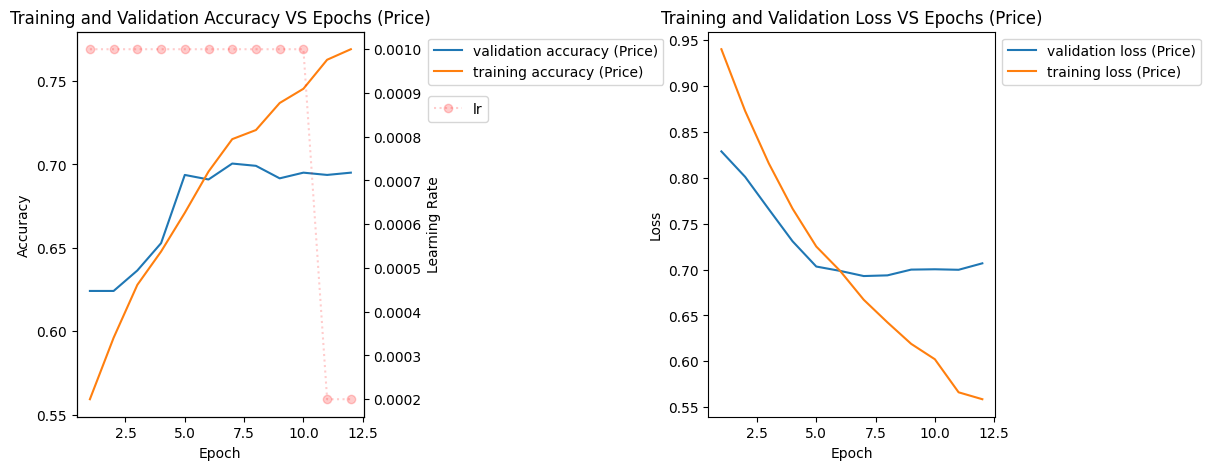

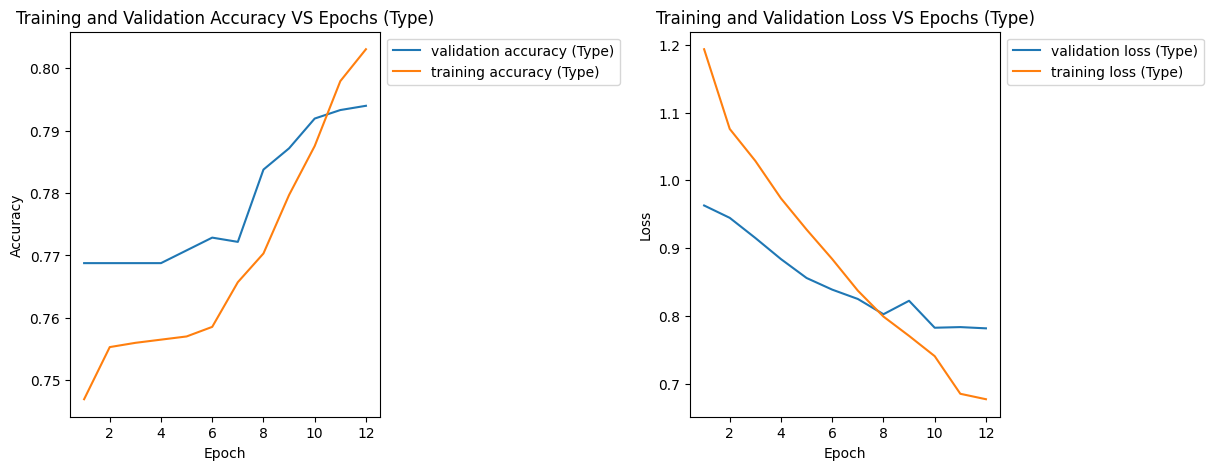

In [ ]:
model_history_plot(history_4)

Model 4 Predictions

In [ ]:
# we can do prediction on training set
y_predict = model_4.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)

230/230 [==============================] - 1s 4ms/step


In [ ]:
# Predicted Price

# probabilities
price_predicted = y_predict['price_catg']
print(price_predicted,"\n")
# categories
price_category_predicted = np.argmax(price_predicted, axis=1) # agrmax -> index of max value
print(price_category_predicted, "\n")
print(np.unique(price_category_predicted, return_counts=True))

[[0.72426623 0.21191564 0.0638181 ]
 [0.8964411  0.09276152 0.01079729]
 [0.870399   0.09856194 0.0310391 ]
 ...
 [0.7972551  0.17367764 0.02906726]
 [0.98448896 0.0135883  0.00192276]
 [0.7511356  0.21619488 0.0326695 ]] 

[0 0 0 ... 0 0 0] 

(array([0, 1, 2]), array([4852, 2482,   26]))


In [ ]:
# Predicted Type

# probabilities
type_predicted = y_predict['aprt_type']
print(type_predicted,"\n")
# categories
type_category_predicted = np.argmax(type_predicted, axis=1) # agrmax -> index of max value
print(type_category_predicted, "\n")
print(np.unique(type_category_predicted, return_counts=True))

[[2.15754868e-03 3.24035197e-01 1.68980435e-02 ... 3.22309881e-03
  8.68911147e-02 4.94642276e-03]
 [2.15216496e-05 9.19607162e-01 1.56875560e-03 ... 9.44474305e-05
  8.51314329e-03 1.15353367e-04]
 [2.33399821e-03 2.23736301e-01 2.27779057e-02 ... 4.27353801e-03
  1.05933785e-01 7.20594823e-03]
 ...
 [1.70823318e-04 7.70231366e-01 4.49044071e-03 ... 4.43189725e-04
  2.56229118e-02 5.90153970e-04]
 [6.71473899e-05 7.84553707e-01 6.97785802e-03 ... 4.09138913e-04
  3.03854588e-02 6.60020858e-04]
 [6.71951420e-05 8.23805034e-01 2.22613756e-03 ... 1.75559602e-04
  1.33474031e-02 2.21622307e-04]] 

[ 1  1 17 ...  1  1  1] 

(array([ 0,  1, 10, 17, 18, 20]), array([   8, 6848,  165,  254,   71,   14]))


Thoughts after trial:
* we notice from the convergence curves that indeed the overfitting has been reduced due to the dropout layers.
* Testing accuracy on Kaggle: 0.6769 which the 3rd performing model and exceeding the previously obtained 0.67146 of the previous model.
* Next we will try to experiment with the input text and see its effect on the prediction accuracy

Model 4 Submission

In [ ]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test_df.id,
     'price': price_category_predicted}
).to_csv('model_4_submission.csv', index=False)

### Model 5 (Simple CNN and GRU Layer with Embedding)
In This model we will start experimenting with the input text.
* since model 1 has the higgest score on Kaggle we will use its simple convolutional layer for the images modality.
* For text modality we will now use a GRU layer which will be given the embedding layer output.
* Then we will concatenate the output of the GRU layer and the flatten vector of the image modality into a single vector for the fully connected layers
* we will also modify the loss_weights parameter during model compile to be optimized for "Price" label

Model 5 Architecture

Thoughts before trial:
* we expect the model to be having good performance as the GRU layer is supposedly better than averaging the embeddings

In [ ]:
import gc
del model_5
tf.keras.backend.clear_session()
gc.collect()

21644

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 6)  114         ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 128, 6)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 6)    0           ['activation[0][0]']         

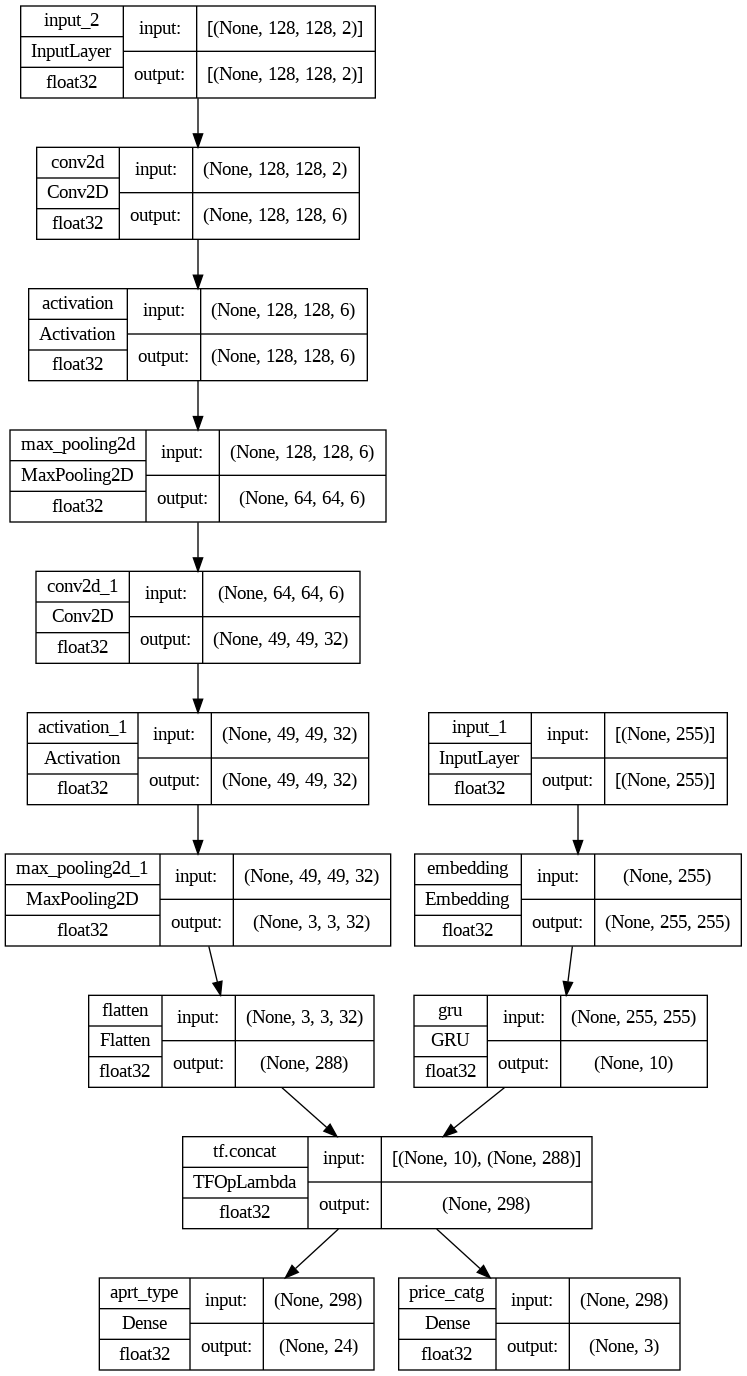

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout, Lambda, Activation, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None,max_len)) # None is batch size
in_image = keras.Input(batch_shape=(None, 128, 128, 2))

# text part
# Embedding(Size of the vocabulary i.e. maximum integer index + 1, Dimension of the dense embedding, Length of input sequences)
embedded = keras.layers.Embedding(input_dim = (x_train_text_id.max()+1), # number of unique words in the dictionary (model vocabulary) -> 9905 + 1
                                  output_dim = x_train_text_id.shape[1], # 255 tokens (based on training text)
                                  input_length = max_len, # 255
                                  )(in_text)
lstm = GRU(units =10, recurrent_dropout = 0.25, recurrent_regularizer='l2')(embedded)

# image part
# simple conv2d.

# number of parameters of each convolutional layer --> (kernel_width * kernel_height * num_filters * num_input_channels) + num_of_filters

cov1 = Conv2D(filters = 6, kernel_size=(3, 3), strides=(1,1), padding='same' )(in_image) # 128x128x6  --> [128 + 2(1) - 3 / 1] + 1 = 128 --> 128x128
actv1 = Activation('relu')(cov1)
pl1 = MaxPool2D((2, 2))(actv1) # 64x64x6   --> [128 + 2(0)-2 / 2 ] + 1 = 64 --> 64x64 note stride of pooling is by default the same as th kernel dimension

cov2 = Conv2D(filters = 32, kernel_size=(16, 16), strides=(1,1), padding='valid' )(pl1) # 49x49x32  --> [64 + 2(0) - 16 / 1] + 1 = 49 --> 49x49
actv2 = Activation('relu')(cov2)
pl2 = MaxPool2D((16, 16))(actv2) # 3x3x32   --> [49 + 2(0)-16 / 16 ] + 1 = 3.06 --> 3x3 note stride of pooling is by default the same as th kernel dimension

flattened = Flatten()(pl2) # 288


# fusion - combinig both
fused = tf.concat([lstm, flattened], axis=-1) # Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
# 255(text vector) + 288 (image vector) = 543


# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(units=len_aprt_type, activation='softmax', name='aprt_type')(fused)
p_price = Dense(units=len_price_categ, activation='softmax', name='price_catg')(fused)


# define model input/output using keys.
model_5 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'aprt_type': p_type,
        'price_catg': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model_5.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'aprt_type': 'sparse_categorical_crossentropy',
        'price_catg': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'aprt_type': 0.0,
        'price_catg': 1.0,  # the higher the value the more to focus on it
    },
    metrics={
        'aprt_type': ['SparseCategoricalAccuracy'],
        'price_catg': ['SparseCategoricalAccuracy'],
    },
)

model_5.summary()
tf.keras.utils.plot_model(model_5, show_shapes=True, show_dtype=True)

Model 5 Training

In [ ]:
%%time
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_price_catg_loss', patience=10, start_from_epoch = 5)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_price_catg_loss',
                                patience=2,
                                verbose=1,
                                factor=0.2,
                                min_delta = 0.01,
                                min_lr=1e-7)

history_5 = model_5.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'aprt_type': y_train_type,
        'price_catg': y_train_price,
    },
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop_callback, lr_reduction],
    verbose=1
)


Epoch 1/30
184/184 [==============================] - 214s 1s/step - loss: 7.5185 - aprt_type_loss: 62.4155 - price_catg_loss: 7.4677 - aprt_type_sparse_categorical_accuracy: 3.4130e-04 - price_catg_sparse_categorical_accuracy: 0.5089 - val_loss: 1.1154 - val_aprt_type_loss: 15.7442 - val_price_catg_loss: 1.0940 - val_aprt_type_sparse_categorical_accuracy: 6.8213e-04 - val_price_catg_sparse_categorical_accuracy: 0.6085 - lr: 0.0010
Epoch 2/30
184/184 [==============================] - 255s 1s/step - loss: 1.1016 - aprt_type_loss: 11.5544 - price_catg_loss: 1.0906 - aprt_type_sparse_categorical_accuracy: 1.7065e-04 - price_catg_sparse_categorical_accuracy: 0.5582 - val_loss: 0.9797 - val_aprt_type_loss: 10.5741 - val_price_catg_loss: 0.9753 - val_aprt_type_sparse_categorical_accuracy: 6.8213e-04 - val_price_catg_sparse_categorical_accuracy: 0.6091 - lr: 0.0010
Epoch 3/30
184/184 [==============================] - 248s 1s/step - loss: 0.9328 - aprt_type_loss: 8.8636 - price_catg_loss: 0.

dict_keys(['loss', 'aprt_type_loss', 'price_catg_loss', 'aprt_type_sparse_categorical_accuracy', 'price_catg_sparse_categorical_accuracy', 'val_loss', 'val_aprt_type_loss', 'val_price_catg_loss', 'val_aprt_type_sparse_categorical_accuracy', 'val_price_catg_sparse_categorical_accuracy', 'lr'])


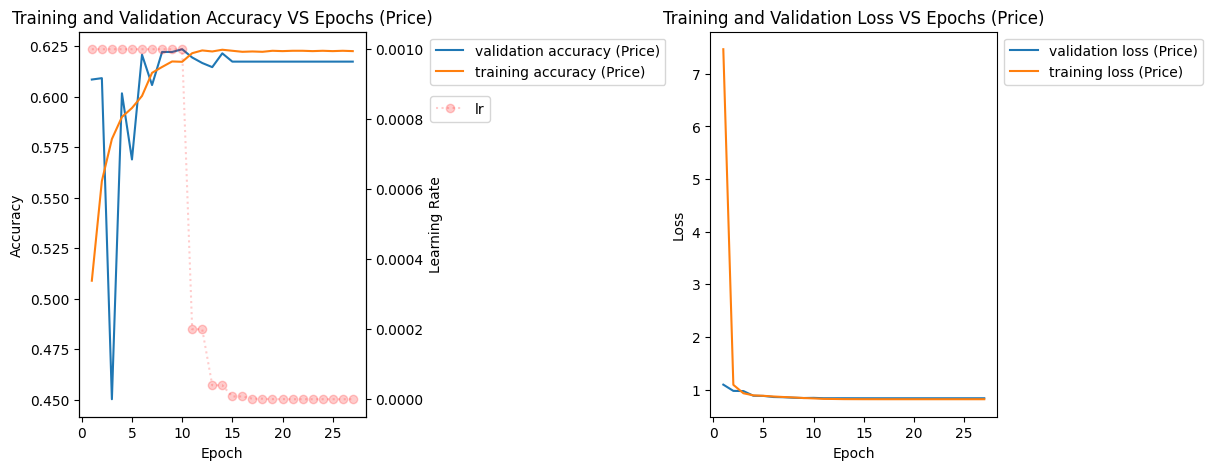

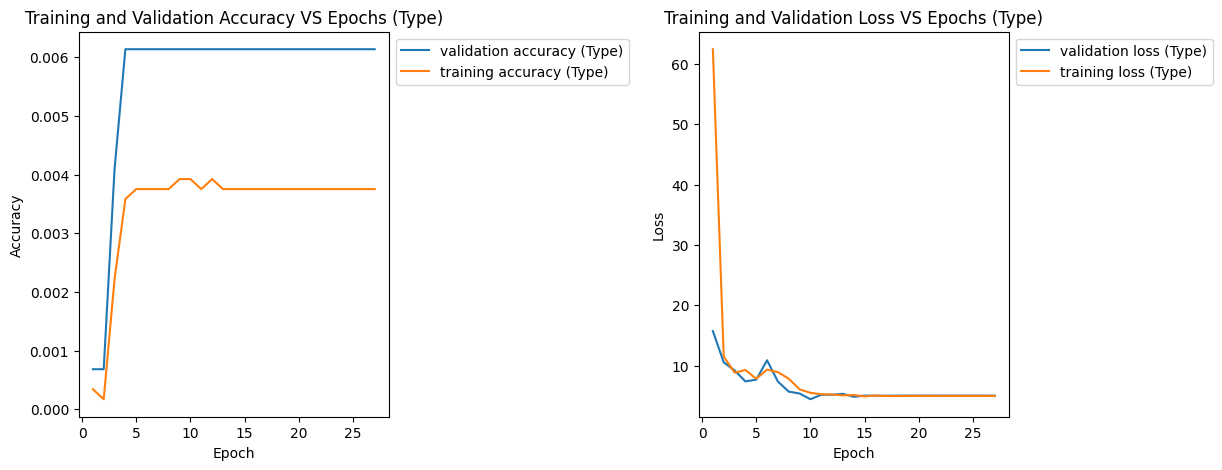

In [ ]:
model_history_plot(history_5)

Model 5 Predictions

In [ ]:
# we can do prediction on training set
y_predict = model_5.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)

230/230 [==============================] - 22s 93ms/step


In [ ]:
# Predicted Price

# probabilities
price_predicted = y_predict['price_catg']
print(price_predicted,"\n")
# categories
price_category_predicted = np.argmax(price_predicted, axis=1) # agrmax -> index of max value
print(price_category_predicted, "\n")
print(np.unique(price_category_predicted, return_counts=True))

[[0.6845161  0.26558158 0.04990241]
 [0.6451669  0.27844065 0.07639249]
 [0.646031   0.27928147 0.07468759]
 ...
 [0.67941725 0.2677791  0.05280359]
 [0.73219174 0.21605922 0.05174902]
 [0.67024475 0.26861823 0.06113698]] 

[0 0 0 ... 0 0 0] 

(array([0, 1]), array([7231,  129]))


In [ ]:
np.unique(price_category_predicted, return_counts=True)

(array([0, 1]), array([7231,  129]))

In [ ]:
# Predicted Type

# probabilities
type_predicted = y_predict['aprt_type']
print(type_predicted,"\n")
# categories
type_category_predicted = np.argmax(type_predicted, axis=1) # agrmax -> index of max value
print(type_category_predicted, "\n")
print(np.unique(type_category_predicted, return_counts=True))

[[0.04300843 0.00956926 0.13809425 ... 0.04320325 0.00614684 0.0425887 ]
 [0.03609354 0.00848208 0.16940783 ... 0.04886331 0.00470273 0.04597363]
 [0.02403897 0.00679666 0.23327546 ... 0.04168521 0.00319254 0.03854951]
 ...
 [0.04159836 0.00635365 0.1646105  ... 0.04262017 0.00450241 0.0258272 ]
 [0.03995024 0.00707187 0.19910449 ... 0.03772001 0.00242428 0.05666931]
 [0.04072187 0.00755883 0.22010238 ... 0.04529404 0.00269355 0.03687853]] 

[2 2 2 ... 2 2 2] 

(array([ 2,  3,  4,  5,  6,  9, 11, 14, 17, 18, 20, 21]), array([7255,    9,    2,   70,    2,    3,    3,    5,    1,    1,    7,
          2]))


Thoughts after trial:
* From convergence curves the model is clearly undefitting
* This underfitting maybe due to using a small number of units in the GRU layer
* Model needs to be more complex in the path dealing with the text input as we have seen before that the images cnn path is good enough so the issue is in the GRU layer.
* The obtained testing accuracy is 0.61711 which is the worst till now
* One other possible cause of underfitting is that we used dropout in the GRU unit and also l2 regularization so this might have been to much for a simple model which lead to underfitting.
* Since the GRU layer took long time to train instead in the next trail we will try using simple RNN layer with bidirectional layer to get info from the future words as well as the past ones.


Model 5 Submission

In [ ]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test_df.id,
     'price': price_category_predicted}
).to_csv('model_5_submission.csv', index=False)

### Model 6 (Simple CNN and Simple Bidirectional RNN with Embedding )
* In this final trial we will be using a simple RNN layer instead of the GRU and will also introduce bidirectional layer to get info from the future words as well as the past ones in aim of making the model more complex but also dont consume much time as GRU layer.
* For image modality we will still use the same CNN of model 1 and model 5.
* We will aslo remove the recurrent_dropout from the SimpleRNN layer to avoid underfitting.
* we will also modify the loss_weights parameter during model compile to be optimized for "Price" label



Model 6 Architecture

Thoughts before trial

* We will increase the number of the units of the SimpleRNN layer and will add the bidirectional layer as from previous model we have seen that insufficient complexity in the text path leads to underfitting so the added complexity now will hopefully improve the model performance.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 6)  114         ['input_4[0][0]']                
                                                                                                  
 activation (Activation)        (None, 128, 128, 6)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 6)    0           ['activation[0][0]']         

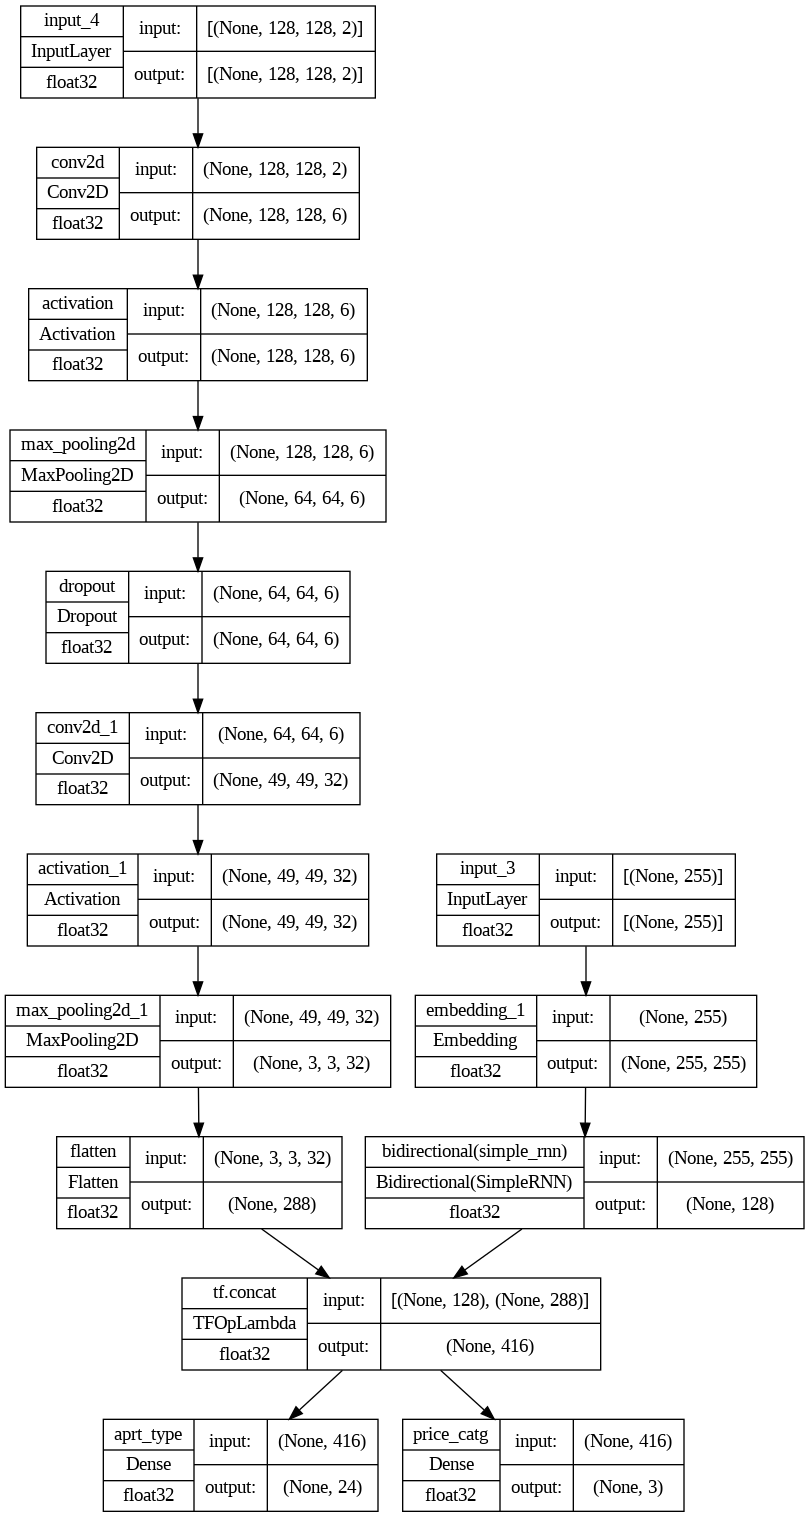

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout, Lambda, Activation, Bidirectional, SimpleRNN
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None,max_len)) # None is batch size
in_image = keras.Input(batch_shape=(None, 128, 128, 2))

# text part
# Embedding(Size of the vocabulary i.e. maximum integer index + 1, Dimension of the dense embedding, Length of input sequences)
embedded = keras.layers.Embedding(input_dim = (x_train_text_id.max()+1), # number of unique words in the dictionary (model vocabulary) -> 9905 + 1
                                  output_dim = x_train_text_id.shape[1], # 255 tokens (based on training text)
                                  input_length = max_len, # 255
                                  )(in_text)
# the output of Embedding layer is (None,255,255) which is None(batch size), 255 (input length of "each word") x 255 (Dimension of the dense embedding "word" projection value for each axis)

# Bidirectional Simple RNN Layer
bidir_simple_rnn = Bidirectional(SimpleRNN(64,recurrent_regularizer='l2'))(embedded)
# output is 128

# image part
# simple conv2d.

# number of parameters of each convolutional layer --> (kernel_width * kernel_height * num_filters * num_input_channels) + num_of_filters


cov1 = Conv2D(filters = 6, kernel_size=(3, 3), strides=(1,1), padding='same' )(in_image) # 128x128x6  --> [128 + 2(1) - 3 / 1] + 1 = 128 --> 128x128
actv1 = Activation('relu')(cov1)
pl1 = MaxPool2D((2, 2))(actv1) # 64x64x6   --> [128 + 2(0)-2 / 2 ] + 1 = 64 --> 64x64 note stride of pooling is by default the same as th kernel dimension

drop1 = Dropout(rate = 0.1)(pl1)

cov2 = Conv2D(filters = 32, kernel_size=(16, 16), strides=(1,1), padding='valid' )(drop1) # 49x49x32  --> [64 + 2(0) - 16 / 1] + 1 = 49 --> 49x49
actv2 = Activation('relu')(cov2)
pl2 = MaxPool2D((16, 16))(actv2) # 3x3x32   --> [49 + 2(0)-16 / 16 ] + 1 = 3.06 --> 3x3 note stride of pooling is by default the same as th kernel dimension

flattened = Flatten()(pl2) # 288


# fusion - combinig both
fused = tf.concat([bidir_simple_rnn, flattened], axis=-1) # Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
# 255(text vector) + 36 (image vector) = 383


# multi-task learning (each is a multi-class classification)
# one dense layer for each task


p_type = Dense(units=len_aprt_type, activation='softmax', name='aprt_type')(fused)
p_price = Dense(units=len_price_categ, activation='softmax', name='price_catg')(fused)


# define model input/output using keys.
model_6 = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'aprt_type': p_type,
        'price_catg': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss
# weights for each task.
model_6.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'aprt_type': 'sparse_categorical_crossentropy',
        'price_catg': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'aprt_type': 0.1,
        'price_catg': 0.9,  # the higher the value the more to focus on it
    },
    metrics={
        'aprt_type': ['SparseCategoricalAccuracy'],
        'price_catg': ['SparseCategoricalAccuracy'],
    },
)

model_6.summary()
tf.keras.utils.plot_model(model_6, show_shapes=True, show_dtype=True)

Model 6 Training

In [ ]:
import gc
del model_6
tf.keras.backend.clear_session()
gc.collect()

In [ ]:
%%time
# defining early stop criteria
earlystop_callback =  keras.callbacks.EarlyStopping(monitor='val_price_catg_loss', patience=5, start_from_epoch = 3)

# defining learning rate scheduler
lr_reduction = ReduceLROnPlateau(monitor='val_price_catg_loss',
                                patience=2,
                                verbose=1,
                                factor=0.5,
                                min_delta = 0.001,
                                min_lr=1e-7)

history_6 = model_6.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'aprt_type': y_train_type,
        'price_catg': y_train_price,
    },
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop_callback, lr_reduction],
    verbose=1
)


Epoch 1/20
184/184 [==============================] - 144s 714ms/step - loss: 12.0539 - aprt_type_loss: 14.3397 - price_catg_loss: 10.6783 - aprt_type_sparse_categorical_accuracy: 0.6061 - price_catg_sparse_categorical_accuracy: 0.5532 - val_loss: 1.5818 - val_aprt_type_loss: 0.9614 - val_price_catg_loss: 0.7829 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6432 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 129s 702ms/step - loss: 1.3720 - aprt_type_loss: 0.9945 - price_catg_loss: 0.6959 - aprt_type_sparse_categorical_accuracy: 0.7560 - price_catg_sparse_categorical_accuracy: 0.6916 - val_loss: 1.2840 - val_aprt_type_loss: 0.9369 - val_price_catg_loss: 0.7184 - val_aprt_type_sparse_categorical_accuracy: 0.7688 - val_price_catg_sparse_categorical_accuracy: 0.6794 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 142s 769ms/step - loss: 1.0448 - aprt_type_loss: 0.9738 - price_catg_loss: 0.5038 - a

dict_keys(['loss', 'aprt_type_loss', 'price_catg_loss', 'aprt_type_sparse_categorical_accuracy', 'price_catg_sparse_categorical_accuracy', 'val_loss', 'val_aprt_type_loss', 'val_price_catg_loss', 'val_aprt_type_sparse_categorical_accuracy', 'val_price_catg_sparse_categorical_accuracy', 'lr'])


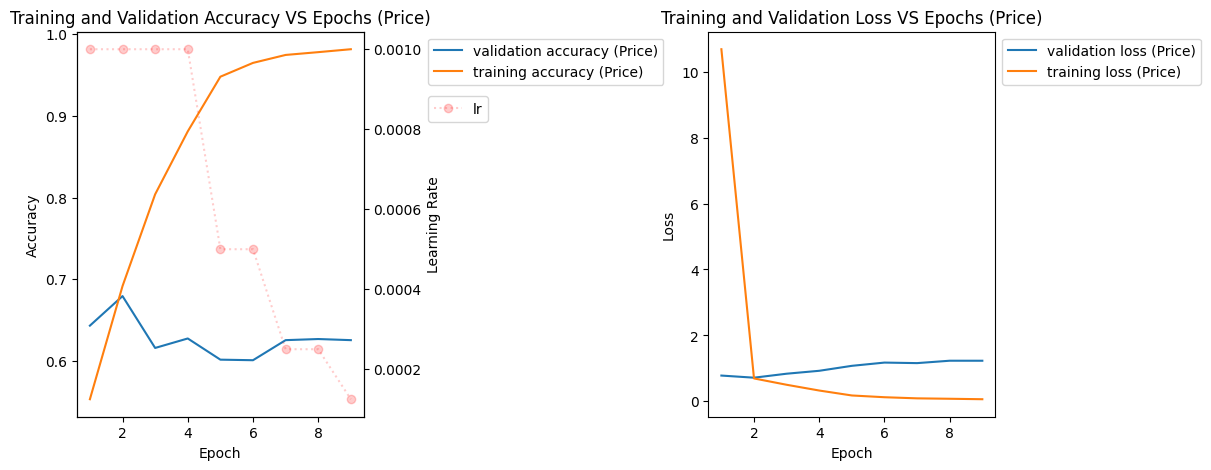

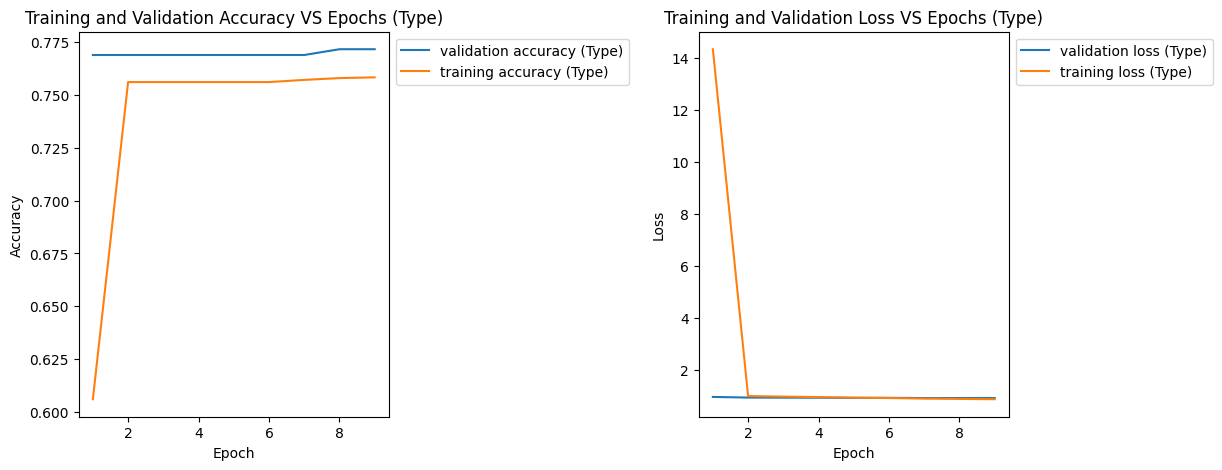

In [ ]:
model_history_plot(history_6)

Model 6 Predictions

In [ ]:
# we can do prediction on training set
y_predict = model_6.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)

230/230 [==============================] - 20s 85ms/step


In [ ]:
# Predicted Price

# probabilities
price_predicted = y_predict['price_catg']
print(price_predicted,"\n")
# categories
price_category_predicted = np.argmax(price_predicted, axis=1) # agrmax -> index of max value
print(price_category_predicted, "\n")
print(np.unique(price_category_predicted, return_counts=True))

[[2.48918999e-02 9.69717383e-01 5.39078237e-03]
 [9.97042596e-01 2.77710054e-03 1.80316856e-04]
 [9.91878152e-01 6.42347522e-03 1.69843645e-03]
 ...
 [9.17495489e-01 8.08257684e-02 1.67880091e-03]
 [8.80379498e-01 1.11297034e-01 8.32346827e-03]
 [9.91959870e-01 3.47401481e-03 4.56611020e-03]] 

[1 0 0 ... 0 0 0] 

(array([0, 1, 2]), array([4928, 2089,  343]))


In [ ]:
# Predicted Type

# probabilities
type_predicted = y_predict['aprt_type']
print(type_predicted,"\n")
# categories
type_category_predicted = np.argmax(type_predicted, axis=1) # agrmax -> index of max value
print(type_category_predicted, "\n")
print(np.unique(type_category_predicted, return_counts=True))

[[8.5379049e-04 7.1347046e-01 3.3302961e-03 ... 9.3204936e-04
  3.0235885e-02 1.0277923e-03]
 [6.3973348e-05 8.7762940e-01 4.0591173e-03 ... 5.0105271e-04
  1.4784855e-02 6.8924460e-04]
 [2.1958684e-04 8.4044015e-01 4.3998361e-03 ... 4.5230353e-04
  1.9107953e-02 8.4918074e-04]
 ...
 [2.6727686e-04 7.9403430e-01 4.3246467e-03 ... 7.7417277e-04
  1.3970299e-02 8.0965774e-04]
 [2.8614033e-04 8.1187421e-01 3.8594317e-03 ... 6.8392255e-04
  2.5286168e-02 1.2654492e-03]
 [2.4863545e-04 7.7024776e-01 3.5171541e-03 ... 7.2437472e-04
  1.9240007e-02 7.8718778e-04]] 

[1 1 1 ... 1 1 1] 

(array([ 0,  1, 10, 17, 18]), array([   2, 7351,    1,    5,    1]))


Thoughts after trial
* from the convergence curves of the trial we can notice that the model is absolutely overfitting.
* This overfitting can maybe due the large number of units in the SimpleRNN and due to not using recurrent_dropout.
* We can try reducing this overfitting by adding the recurrent_dropout or use L1 regularizer instead of L2 that we have used or try reducing the number of the RNN units and chekc the performance.
* The obtained testing accuracy on Kaggle is: 0.61521 (The worst result)

Model 6 Submission

In [ ]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test_df.id,
     'price': price_category_predicted}
).to_csv('model_6_submission.csv', index=False)